Mary Jane the Model
==============

***Using machine earning to reveal insights and predict performance of cannabis dispensaries***

**Author:** *Scott Butters*

# Abstract

In 2012, Washington state passed I-502 and legalized the recreational sale, use, and possession of marijuana. This event has led to an explosion of development in the field that's making waves through our society. Since 2014, approximately 500 state licensed dispensaries have opened throughout the state, with nearly 150 of those here in Seattle. And the thing that gets me excited is that because of regulations, a ton of their data is publicly available, meaning I got to play with it. We can go into the weeds later about how and why it took me a thousand websites and 4 different scraping techniques to get the data, and how my R^2 varied when I went shifted from 10-30 features to estimate the monthly revenue of a cannabis dispensary. But for now, let me tell you about what I learned as I immersed myself in this dataset over the past 2 weeks. In this project I scour the web for publicly available data that might be predictive of how a cannabis dispensary performs, such as customer reviews, inventory distributions, and local demographics. I then train machine learning models to predict a dispensary's monthly revenue and analyze the resulting models to distill insights about what drives sales in the marijuana market.


In this project, I explored the question of what makes the Washington recreational cannabis market tick. I decided that if I could identify the features that most contributed to a dispensary's revenue, I could get a lot of insight out of how the features shake out. 

When asked what my project was, I kept saying that it was to use web scraping to predict monthly revenue using linear regression. And it was, of course it was. But that's not the point, that's not the story. 

Here's the monthly revenue of all dispensaries for the last 16 months. See the trend?

Okay. Now. Here's the monthly revenue of a handful of dispensaries over that same period. See the trend?

But we can show this better. Here's the average monthly change in revenue of a dispensary.
Next to the change for the overall market. 
Next to variation in the S&P 500 over the same period.
And now the top marijuana ETF out there.

So if we're going to make choices about what to invest in to make a dispensary successful, we need to have the impacts of the external market in context. So I put those indicators in there for some regression models to see how significant a role they played.

In at attempt to both have more data and isolate the time component of my analysis, I constructed a new target variable, which is marketshare. For each month, I divided the revenue of a given dispensary by the revenue of all of the dispensaries over that period. 

# Obtain the Data

The data for this project is derived from several sources:

## Dispensary profiles from [Leafly](www.leafly.com)

Leafly is an information aggregator for cannabis. They maintain a profile for most of the dispensaries in the state. As part of my dataset, I've scraped the following features from the Leafly website for each dispensary for which it was available:

* Average customer rating and number of customer reviews
* Inventory counts (number of products under descriptions like "flower", "edibles", "concentrates", etc.
* Categorical qualities, such as whether or not the store is ADA accessible or has an ATM onsite
* Metadata such as name, address, phone number, etc.

The combination of these features gives us a profile of each dispensary that allow us to draw insights from our model into what makes for a successful dispensary.

## Demographics from [WA HomeTownLocator](https://washington.hometownlocator.com/)

Of course, having the best inventory, friendliest staff and prettiest building in the state doesn't amount to anything if a dispensary is in the middle of nowhere. This is where demographic data comes in. WA HomeTownLocator maintains a database of demographic statistics for nearly every zip code in the state of Washington. The data is produced by Esri Demographics, and updated 4 times per year using data from the federal census, IRS, USPS, as well as local data sources and more. From this website I scraped data likely to be predictive of a local market such as:

* Population density
* Diversity
* Average income

These data give our model an image of what a dispensary's customer base is like, allowing us to characterize what makes for a good location to establish a dispensary.

## [Washington State Liquor and Cannabis Board (WSLCB)](https://lcb.wa.gov/)

Lastly, all that data would get us nowhere if we didn't have any target data to train our models on. That's where the WSLCB comes in. The WSLCB maintains data on every dispensary in the state, including monthly reports of revenue (which is what our model is predicting). Their data is scattered across a couple of different outlets, but for this project I used spreadsheets downloadable from [this obsure page](https://lcb.wa.gov/records/frequently-requested-lists) to get sales data dating back to November 2017. Because the only identifying information in that spreadsheet is the license number of the dispensary, I also downloaded a spreadsheet listing metadata for every entity that has applied for a Marijuana license, which I then joined with the sales data in order to link it up with data scraped from other resources.

## Data Collection

The code below contains a pipeline to visit each of our sources and scrape or download all of the desired data into a few files stored in the data/raw/ directory to be scrubbed and processed later.

### Wayback method (diregard)

In [616]:
# ## %%writefile ../src/data/make_dataset.py

# # Imports
# import json
# import os
# import random
# import re
# import requests
# import sys
# import time
# import datetime
# import dateutil.relativedelta

# import numpy as np
# import pandas as pd

# # from fake_useragent import UserAgent
# # from bs4 import BeautifulSoup
# # from selenium import webdriver
# # from selenium.webdriver.common.keys import Keys
# # from selenium.webdriver.common.by import By

# # Helper functions
# def wayback_lookup(url, datestring):
#     """
#     Constructs url for querying Wayback Machine for website snapshot
#     Input: url you want a snapshot for, datestring in format of 'YYYYMMDD' for
#     latest allowable snapshot (will return the most recent up to that date)
#     Output: url to snapshot, datestamp of snapshot
#     """
#     base_url = 'https://archive.org/wayback/available'
#     base_url = '?url='.join([base_url, url])
#     base_url = '&timestamp='.join([base_url, datestring])
    
#     return base_url

    
# def scrape_disp(disp_dict, date):
#     """
#     Scrapes dispensary-specific page on leafly for additional data and adds it
#     to existing dictionary dataset
#     Input: dictionary containing metadata for a single dispensary
#     Output: dictionary with additional metadata for given dispensary
#     """
# #     print(disp_dict)
    
#     datestamp = datetime.datetime.strptime(date, "%Y%m%d").date()
#     month_delta = dateutil.relativedelta.relativedelta(months=1)
#     cutoff = datestamp - month_delta
    
#     slug = disp_dict['slug']
#     url = 'https://www.leafly.com/dispensary-info/' + slug
#     url = wayback_lookup(url, date)
    
#     # Query Wayback machine
#     r = requests.get(url)
#     attrs = r.json()
    
#     # Check if no result
#     if not attrs['archived_snapshots']:
#         print(f"No response for {disp_dict['name']}")
#         return {}
        
#     closest = attrs['archived_snapshots']['closest']
#     url = closest['url']
#     timestamp = closest['timestamp']
#     latest = datetime.datetime.strptime(timestamp, "%Y%m%d%H%M%S").date()
    
#     # Check for fail/cancel conditions
#     r = requests.get(url)
#     if not r.ok:
#         print('Connection to {} failed'.format(disp_dict['name']))
#         return {}
#     if latest < cutoff:
#         print(f"{disp_dict['name']} has no snapshot between {cutoff} and {datestamp}")
#         return {}
    
#     # Get data dict from url response
#     try:
#         jsData = re.search(r'__NEXT_DATA__\s+=\s+(.*)', r.text)
#         data = json.loads(jsData.group(1))
#     except:
#         print(f"Failed, {disp_dict['name']} isn't formatted right")
#         return
              
#     # Fill up dictionary with data
# #     disp_dict = {}

#     try:
#         props = data['props']
#         hasMenu = {'hasMenu': props['hasMenu'] if 'hasMenu' in props.keys() else False}
#         disp_dict.update(hasMenu)
#     except:
#         pass

#     try:
#         disp = props['dispensary']
#         disp_keys = [
#             'acceptsDebitCards', 'created', 'followerCount', 'hasAtm', 
#             'hasVeteranDiscount', 'isAdaAccessible', 'isUfcwMember', 'lastMenuUpdate',
#             'zip', 'isWashington', 'isStorefront']
#         disp_items = {key: disp[key] for key in disp_keys}
#         disp_dict.update(disp_items)
#     except:
#         pass
              
#     try:
#         ratings = disp['ratings']
#         ratings_keys = [
#             'atmosphereRating', 'averageRating', 'easeOfRegistrationRating', 
#             'packagingQualityRating', 'qualityRating', 'reviewCount', 'serviceRating']
#         ratings_items = {key: ratings[key] for key in ratings_keys}
#         disp_dict.update(ratings_items)
#     except:
#         pass

#     try:
#         types = props['facets']['types']
#         products = {p['displayName']: p['docCount'] for p in types}
#         disp_dict.update(products)
#     except:
#         pass

#     print(f'Successfully scraped data for {disp_dict["name"]}')
#     return disp_dict


# def scrape_leafly_disps(path, disp_data_filename, data):
#     """
#     Gets JSON file of data on dispensaries from Leafly, either by loading
#     pre-existing file or by re-scraping Leafly
#     Input: path and filename for output file, index of basic dispensary metadata
#     Output: Index formatted JSON with one dictionary for each found dispensary
#     """
# #     filepath = '../data/raw/dispensary_data.json'
#     filepath = path + disp_data_filename
#     if os.path.isfile(filepath):
#         overwrite = input(
#             '''Dispensaries data dict already exists. Scrape data again? y/n\n
#             Note: this could take several minutes.''')
#         if overwrite.lower() != 'y':
#             with open(filepath) as json_file:
#                 data = json.load(json_file)
#             return data

#     print("Beginning scrape...")
    
#     ## BUILD DATES / CHECK DATES ##
#     dates = ['20190201', '20171101']
#     month_data = {}
#     for date in dates:
#         for disp in data:
# #             print(data[disp]['formattedShortLocation'])
#             if 'OR' not in data[disp]['formattedShortLocation']:
#                 new_data = scrape_disp(data[disp], date)
#                 month_data[' '.join([date, disp])] = new_data
    
#     with open(filepath, 'w') as outfile:  
#         json.dump(month_data, outfile)
#         print('Scraped data written to {}'.format(filepath))
    
#     return month_data

#### TEST HERE

In [623]:
path = '../data/raw/'
    
disp_filename = 'dispensary_list.json'

data = get_leafly_disp_data(path, disp_filename)
print('\nData acquisition complete.\n')

Initial dispensary list already exists. Scrape data again? y/n
 
            Note: this could take several minutes.n
Dispensaries data dict already exists. Scrape data again? y/n

            Note: this could take several minutes.y
Beginning scrape...
No response for Mister Buds
No response for Origins Port Angeles
No response for Cannabis Coast
Successfully scraped data for Lux Pot Shop - Ballard
No response for Nature's Gifts - Sequim
Paper and Leaf - Bainbridge Island has no snapshot between 2019-01-01 and 2019-02-01
No response for South Bellingham Buds
Ruckus - Seattle has no snapshot between 2019-01-01 and 2019-02-01
No response for Reefer Den
Mary's - Seattle has no snapshot between 2019-01-01 and 2019-02-01
No response for Sweet Relief - Mount Vernon
Successfully scraped data for Rainier Cannabis - Mountlake Terrace
Lux Pot Shop - Lake City has no snapshot between 2019-01-01 and 2019-02-01
No response for Green 101
No response for The Reef - Seattle
No response for Uncle Ike's 

Kushman's - Mukilteo has no snapshot between 2019-01-01 and 2019-02-01
KushMart - Everett has no snapshot between 2019-01-01 and 2019-02-01
The Kushery at Cathcart has no snapshot between 2019-01-01 and 2019-02-01
No response for Origins - Redmond
Green Lady - Lynnwood has no snapshot between 2019-01-01 and 2019-02-01
No response for The Vault - Lake Stevens
No response for High Society
Euphorium in Woodinville has no snapshot between 2019-01-01 and 2019-02-01
No response for Bud Hut - Snohomish
PRC - Arlington has no snapshot between 2019-01-01 and 2019-02-01
The Novel Tree - Bellevue has no snapshot between 2019-01-01 and 2019-02-01
WCW / West Coast Wellness - Recreational has no snapshot between 2019-01-01 and 2019-02-01
PuffnChill - Lynnwood has no snapshot between 2019-01-01 and 2019-02-01
No response for Local Roots Marijuana - Granite Falls
No response for The Vault - Stanwood
The Kushery - Clearview has no snapshot between 2019-01-01 and 2019-02-01
No response for Marijuana Clu

Natures Recreational Center - Tacoma, Washington has no snapshot between 2019-01-01 and 2019-02-01
Ganja Goddess has no snapshot between 2019-01-01 and 2019-02-01
No response for The Reef - Bremerton
Legal Marijuana Superstore - Recreational has no snapshot between 2019-01-01 and 2019-02-01
No response for Cutie Judy's Cannabis Co
Lucid - Lacey has no snapshot between 2019-01-01 and 2019-02-01
No response for High Society - Tacoma
No response for TJ's Cannabis
No response for THC - Olympia
Olympia Weed Co. - fka Northwest Collective has no snapshot between 2019-01-01 and 2019-02-01
No response for NiMBiN Pot Shop
Star 21 has no snapshot between 2019-01-01 and 2019-02-01
No response for Lucid - Puyallup
The Joint - Tacoma has no snapshot between 2019-01-01 and 2019-02-01
Failed, Euphoric360 isn't formatted right
No response for Elite - Lacey
No response for III King Company - Recreational
No response for The Evergreen Market - South Renton
No response for Canna Republic
No response for 

Cannarex has no snapshot between 2017-10-01 and 2017-11-01
Dockside Cannabis in Shoreline has no snapshot between 2017-10-01 and 2017-11-01
2020 Solutions - Guide Meridian has no snapshot between 2017-10-01 and 2017-11-01
Whidbey Island Cannabis Company - Recreational has no snapshot between 2017-10-01 and 2017-11-01
Greenside Recreational Seattle has no snapshot between 2017-10-01 and 2017-11-01
No response for Bud Hut - Camano Island
No response for Clear Choice Cannabis - Bremerton
No response for Seaweed Cannabis - Edmonds
No response for Dockside Cannabis in Ballard
A Greener Today - Shoreline has no snapshot between 2017-10-01 and 2017-11-01
Successfully scraped data for Greenworks - Greenwood
No response for The Bakeréé - Aurora - Open Now!
Failed, Have a Heart - Belltown isn't formatted right
Agate Dreams has no snapshot between 2017-10-01 and 2017-11-01
No response for Western Bud Cannabis Co. - Burlington
Successfully scraped data for Local Roots Marijuana - Edmonds
Loving Fa

Savage THC - Recreational has no snapshot between 2017-10-01 and 2017-11-01
Failed, Cinder - Spokane Valley isn't formatted right
Cannabis and Glass - Spokane has no snapshot between 2017-10-01 and 2017-11-01
Satori - Spokane has no snapshot between 2017-10-01 and 2017-11-01
TreeHouse Club has no snapshot between 2017-10-01 and 2017-11-01
No response for The Hidden Joint Recreational - Spokane
No response for Lovely Buds Division
Lovely Buds - Spokane has no snapshot between 2017-10-01 and 2017-11-01
No response for Access Canibus
No response for Pend Oreille Cannabis Co.
No response for Lucid - Spokane
No response for Lovely Buds North - Spokane
Cannabis and Glass - Spokane Valley has no snapshot between 2017-10-01 and 2017-11-01
Successfully scraped data for Green Light - Spokane
No response for Mary Jane's - Spokane
Royal's Cannabis Medical/Recreational - Spokane has no snapshot between 2017-10-01 and 2017-11-01
The Green Nugget has no snapshot between 2017-10-01 and 2017-11-01
No r

Successfully scraped data for American Harvest
Happy Time - Recreational has no snapshot between 2017-10-01 and 2017-11-01
No response for Cannabis Superstore - Cle Elum
Green Life Cannabis - Wenatchee has no snapshot between 2017-10-01 and 2017-11-01
No response for Roslyn Herbs
No response for The Happy Crop Shoppe - Cashmere
No response for Yakima Weed Company
No response for The Slow Burn - Market Street
No response for The Fire House
No response for Bad Ass Weed Co
Cannabis Central has no snapshot between 2017-10-01 and 2017-11-01
No response for The Green Shelf
No response for Station 420 - Union Gap
No response for Sweet Relief - Yakima
No response for Happy Trees
The Green Seed - Recreational has no snapshot between 2017-10-01 and 2017-11-01
No response for GoodBuds - Quincy
No response for 2020 Solutions - Ephrata
Apex Cannabis - Moses Lake has no snapshot between 2017-10-01 and 2017-11-01
No response for Mary Janes - Moses Lake
No response for The Grass Station - George
No re

In [625]:
data = pd.read_json(path + disp_filename, orient='index')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 635 entries, Mister Buds to Canna4Life - Clarkston
Data columns (total 45 columns):
Accessory                   9 non-null float64
All                         9 non-null float64
All Products                44 non-null float64
Cartridge                   12 non-null float64
Clone                       9 non-null float64
Concentrate                 51 non-null float64
Edible                      51 non-null float64
Flower                      52 non-null float64
Other                       44 non-null float64
PreRoll                     9 non-null float64
Preroll                     41 non-null float64
Seeds                       9 non-null float64
Topical                     11 non-null float64
acceptsDebitCards           57 non-null float64
address1                    633 non-null object
address2                    134 non-null object
atmosphereRating            57 non-null float64
averageRating               57 non-null float64
city        

In [627]:
data

,Accessory,All,All Products,Cartridge,Clone,Concentrate,Edible,Flower,Other,PreRoll,Preroll,Seeds,Topical,acceptsDebitCards,address1,address2,atmosphereRating,averageRating,city,created,easeOfRegistrationRating,followerCount,formattedShortLocation,hasAtm,hasMenu,hasVeteranDiscount,isAdaAccessible,isStorefront,isUfcwMember,isWashington,lastMenuUpdate,location,medical,name,numberOfReviews,packagingQualityRating,phone,qualityRating,recreational,reviewCount,serviceRating,slug,starRating,tier,zip
Mister Buds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,536 Marine Dr,None,NaN,NaN,Port Angeles,NaN,NaN,NaN,"Port Angeles, WA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-04-10T17:54:28.278868+00:00,"{'lat': 48.1219849, 'lon': -123.4437221}",0,Mister Buds,3,NaN,(360) 797-1966,NaN,1,NaN,NaN,mister-buds,5.000000,900,NaN
Origins Port Angeles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1215 E Front Street,None,NaN,NaN,Port Angeles,NaN,NaN,NaN,"Port Angeles, WA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-12T01:37:53.395365+00:00,"{'lat': 48.1115394, 'lon': -123.4118052}",0,Origins Port Angeles,26,NaN,360.406.4902,NaN,1,NaN,NaN,sparket-rnr,4.961538,300,NaN
Cannabis Coast,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,193161 Highway 101,None,NaN,NaN,Forks,NaN,NaN,NaN,"Forks, WA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-04-07T23:37:15.980746+00:00,"{'lat': 47.9683179, 'lon': -124.404138}",0,Cannabis Coast,2,NaN,(360) 374-4020,NaN,1,NaN,NaN,cannabis-coast,5.000000,900,NaN
Lux Pot Shop - Ballard,NaN,NaN,2796.0,NaN,NaN,610.0,784.0,641.0,49.0,NaN,712.0,NaN,NaN,1.0,4912 17th Ave NW,None,4.340000,4.360000,Seattle,2015-09-02T23:58:31.264304+00:00,0.0,319.0,"Seattle, WA",1.0,1.0,0.0,1.0,1.0,0.0,1.0,2019-02-22T10:02:13.642866+00:00,"{'lat': 47.6648419, 'lon': -122.3786413}",0,Lux Pot Shop - Ballard,52,0.0,206-294-5586,4.460000,1,50.0,4.360000,stash-pot-shop,4.358974,200,98107.0
Nature's Gifts - Sequim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,755 W Washington St,Suite C,NaN,NaN,Sequim,NaN,NaN,NaN,"Sequim, WA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-12T03:17:37.187515+00:00,"{'lat': 48.0791305, 'lon': -123.1204523}",0,Nature's Gifts - Sequim,19,NaN,360-797-1993,NaN,1,NaN,NaN,natures-gifts-sequim,4.594737,300,NaN
Paper and Leaf - Bainbridge Island,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8040 Day Road West,Building 3 Unit 1,NaN,NaN,Bainbridge Island,NaN,NaN,NaN,"Bainbridge Island, WA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-07-26T21:05:10.411478+00:00,"{'lat': 47.6803888, 'lon': -122.5413752}",0,Paper and Leaf - Bainbridge Island,56,NaN,206-780-7814,NaN,1,NaN,NaN,paper-and-leaf,4.700000,900,NaN
South Bellingham Buds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1215 N Lake Samish Drive,1,NaN,NaN,Bellingham,NaN,NaN,NaN,"Bellingham, WA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-02-09T23:48:52.824509+00:00,"{'lat': 48.685436, 'lon': -122.398066}",0,South Bellingham Buds,5,NaN,360-778-3358,NaN,1,NaN,NaN,bonanza-buds,5.000000,900,NaN
Ruckus - Seattle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1465 E Republican St,None,NaN,NaN,Seattle,NaN,NaN,NaN,"Seattle, WA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-16T00:11:03.129886+00:00,"{'lat': 47.62297050000001, 'lon': -122.3129892}",0,Ruckus - Seattle,136,NaN,206-257-4805,NaN,1,NaN,NaN,ruckus,4.665686,900,NaN
Reefer Den,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2123 W Sims Way,None,NaN,NaN,Port Townsend,NaN,NaN,NaN,"Port Townsend, WA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-11T22:08:38.713447+00:00,"{'lat': 48.1030757, 'lon': -122.800633}",0,Reefer Den,2,NaN,(360) 344-2510,NaN,1,NaN,NaN,reefer-den,4.833333,300,NaN
Mary's - Seattle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12230 Aurora Ave N,None,NaN,NaN,Seattle,NaN,NaN,NaN,"Seattle, WA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-08T23:21:36.579853+00:00,"{'lat': 47.7187776, 'lon': -122.3444577}",0,Mary's - Seattle,82,NaN,206-687-7780,NaN,1,NaN,NaN,marys,4.691870,200,NaN


In [573]:
def retry(TL_lat, TL_lon, cell_size):
    '''
    If request hits Leafly API limit, split cell into 4 subcells and retry
    Input: Lat/lon coordinates for top left of map and optionally a size for
    the map area (defaults to 0.5)
    Output: dictionary of dictionaries containing metadata for each dispensary 
    found in map area
    '''
    TL_lats = [TL_lat, TL_lat - 0.4 * cell_size]
    TL_lons = [TL_lat, TL_lat + 0.4 * cell_size]
    disp_data = {}
    for lat, lon in zip(TR_lats, TR_lons):
        data = get_disp_data_by_coords(lat, lon, cell_size=0.6 * cell_size)
        disp_data.update(data)
    return disp_data


def get_disp_data_by_coords(TL_lat, TL_lon, cell_size=0.5):
    """
    Performs search for all dispensaries within a map region on Leafly
    Input: Lat/lon coordinates for top left of map and optionally a size for
    the map area (defaults to 0.5)
    Output: dictionary of dictionaries containing metadata for each dispensary 
    found in map area
    """
    # Setup
    BR_lat = TL_lat - cell_size
    BR_lon = TL_lon + cell_size
    coords = TL_lat, TL_lon, BR_lat, BR_lon
    
    url = (
        'https://web-finder.leafly.com/api/searchThisArea?topLeftLat={}&topLeftLon={}&bottomRightLat={}&bottomRightLon={}&userLat=47.6&userLon=-122.3'
        ).format(TL_lat, TL_lon, BR_lat, BR_lon)
    
    # Scrape
    time.sleep(.5+2*random.random())
    r = requests.get(url)
    if r.status_code != 200:
        print('Leafly search failed at {}'.format(coords))
        return {}
    disps = r.json()
    
    # Parse
    fields = ['name', 'address1', 'address2', 'city', 'location', 'phone',
              'formattedShortLocation', 'medical', 'recreational', 'tier', 
              'lastMenuUpdate', 'starRating', 'numberOfReviews', 'slug']

    disp_data = {
        d['name']: {k: d[k] for k in fields} for d in disps['dispensaries']}
    entries = len(disp_data)
    
    # Check results; retry if necessary and return data
    if entries > 200:
        return retry(TR_lat, TR_lon, cell_size)
    elif entries < 1:
#         print('no results at {}'.format(coords))
        return {}
    else:
#         print('{} results found at {}'.format(len(disp_data), coords))
        return disp_data
    
    
def get_rect_disp_data(TL_lat, TL_lon, BR_lat, BR_lon, cell_size=0.5):
    """
    Performs grid search on sub-rectangles with slight overlap, gathering data 
    on each cell
    Input: lat/lon coords of top left and bottom right corners, as well as 
    optional cell size parameter (defaults to 0.5)
    Output: dictionary of dictionaries representing all dispensaries in
    rectangle
    """
    coords = TL_lat, TL_lon, BR_lat, BR_lon
    max_step = 0.8 * cell_size
    lat_steps = np.ceil((TL_lat - BR_lat - cell_size) / max_step)
    lon_steps = np.ceil((BR_lon - TL_lon - cell_size) / max_step)

    TL_lats = np.linspace(TL_lat, BR_lat + cell_size, lat_steps + 1)
    TL_lons = np.linspace(TL_lon, BR_lon - cell_size, lon_steps + 1)

    disp_data = {}

    for lat in TL_lats:
        for lon in TL_lons:
            data = get_disp_data_by_coords(lat, lon, cell_size)
            disp_data.update(data)

    print('Total dispensaries found: ', len(disp_data))
    return disp_data


def get_disp_dict(path):
    """
    Performs a grid search across Washington for all dispensaries with an
    account on Leafly and scrapes metadata for each
    Input: relative path to raw data directory
    Output: Index formatted JSON with one dictionary for each found dispensary
    """
    filepath = path + 'dispensary_list.json'
    
    if os.path.isfile(filepath):
        overwrite = input(
            '''Initial dispensary list already exists. Scrape data again? y/n\n 
            Note: this could take several minutes.''')
        if overwrite.lower() != 'y':
            with open(filepath) as json_file:
                data = json.load(json_file)
            return data
    print("Beginning scrape...")
    
    # WA State bounding coordinates
    north = 49
    west = -124.8
    south = 45.4
    east = -116.8
    
    data = get_rect_disp_data(north, west, south, east, cell_size=1.4)
    
    with open(filepath, 'w') as outfile:  
        json.dump(data, outfile)
        print('Scraped data written to {}'.format(filepath))
        
    return data


def get_leafly_disp_data(path, disp_filename):
    """
    Steps through all helper functions to scrape data from Leafly
    Input: raw data path and desired filename for output
    Output: JSON file containing scraped data
    """
    disp_dict = get_disp_dict(path)
    disp_data = scrape_leafly_disps(path, disp_filename, disp_dict)
    return disp_data


def get_demo_data(path, license_filename, demo_filename):
    """
    Scrapes zip code based demographic data from washington.hometownlocator.com
    for all zip codes containing a dispensary found in WSLCB license data
    Input: relative path to raw data directory, license data filename, 
    demographics data filename
    Output: saves demographic dataset to csv in raw data directory
    """
    license_filepath = path + license_filename
    demo_filepath = path + demo_filename

    if os.path.isfile(demo_filepath):
        overwrite = input(
            '''Demographics file already exists. Scrape data again? y/n\n 
            Note: this could take several minutes.''')
        if overwrite.lower() != 'y':
            return
    
    license_data = pd.read_excel(license_filepath, sheet_name=2, header=0)
    zips = license_data['ZipCode'].astype(str).str[:5].unique()
    demographics = pd.DataFrame()
    
    print("Beginning scrape...")
    for zip_code in sorted(zips):
        url = f'https://washington.hometownlocator.com/zip-codes/data,zipcode,{zip_code}.cfm'
        r = requests.get(url)
        if 'table' in r.text:
            df0, df1 = pd.read_html(url, index_col=0)[:2]
            df0.columns = [str(zip_code)]
            df1.columns = [str(zip_code)]
            df = pd.concat([df0, df1], axis=0).T.dropna(axis=1)
            df.drop(['INCOME', 'HOUSEHOLDS'], axis=1, inplace=True)
            demographics = pd.concat([demographics, df])
            print('Scraped {}/{} zips. Latest: {}'
                  .format(len(demographics), len(zips), zip_code), end='\r')
            sys.stdout.flush()
        else:
            print(f'\nNo data found for {zip_code}')
        
    demographics.to_csv(demo_filepath)
    print('Scraped data written to {}'.format(demo_filepath))
    return
    
    
def download_dataset(url, path, filename):
    """
    Downloads dataset from specified url and saves file to raw data directory
    Input: url from which to retrieve data, filename to store data in
    Output: dataset stored in raw data file directory
    """
#     filepath = '../data/raw/{}'.format(filename)
    filepath = path + filename
    file_exists = os.path.isfile(filepath)
    if file_exists:
        overwrite = input('{} already exists. Update? y/n'.format(filename))
        if overwrite.lower() != 'y':
            return
    print("Beginning file download...")
    r = requests.get(url)
    if not r.ok:
        print('Download failed')
        return
    with open(filepath, 'wb') as f:  
        f.write(r.content)
    print('File written to {}\n'.format(filepath))
    return
    
    
def get_sales_data(path, sales_filename, license_filename):
    """
    Gets links for most up-to-date dispensary sales and license information
    from WSLCB and downloads datasets
    Input:
    Output: downloaded files to raw data directory
    """
    # Get urls for most up-to-date sales and license data
    url = 'https://lcb.wa.gov/records/frequently-requested-lists'
    response = requests.get(url)
    if response.ok:
        soup = BeautifulSoup(response.text, "html.parser")
        links = soup.find_all('a')
        for link in links:
            if 'Traceability' in link.text:
                sales_url = link['href']
                print(f'\nLatest sales data found:\n{sales_url}')
                #filename = 'sales_data.xlsx'
                download_dataset(sales_url, path, sales_filename)
            elif 'Applicants' in link.text:
                licenses_url = link['href']
                print(f'\nLatest license data found:\n{licenses_url}')
                #filename = 'license_data.xls'
                download_dataset(licenses_url, path, license_filename)
    else:
        print('Failed to download sales data')

    return

    
def run():
    """
    Executes a set of helper functions that download data several
    sources and saves those datasets to the data/raw directory.
    """
    path = '../data/raw/'
    
    sales_filename = 'sales_data.xlsx'
    license_filename = 'license_data.xls'
    demo_filename = 'demographics.csv'
    disp_filename = 'dispensary_data.json'
    
    get_sales_data(path, sales_filename, license_filename)
    get_demo_data(path, license_filename, demo_filename)
    get_leafly_disp_data(path, disp_filename)
    
    print('\nData acquisition complete.\n')
    return

## No historical data

In [811]:
## %%writefile ../src/data/make_dataset.py

# Imports
import json
import os
import random
import re
import requests
import sys
import time

import numpy as np
import pandas as pd

from fake_useragent import UserAgent
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

In [628]:
# Helper functions
def parse_products(text):
    '''
    Parses string of products into dictionary of products with counts
    Input: string of products as scraped from Leafly dispensary page
    Output: dictionary of {product: count} relationships
    '''
    repl = ['(', ')']
    for char in repl:
        text = text.replace(char, '')
    prod_list = text.split('\n')
    prod_list = [prod.strip().lower() for prod in prod_list]
    prod_dict = {}
    for i, element in enumerate(prod_list):
        if element.isnumeric():
            prod_dict[prod_list[i - 1]] = int(element)
        elif 'difference' in element:
            pass
        else:
            prod_dict[element.strip()] = 0
    return prod_dict


def scrape_disp(disp, driver, user_agent):
    """
    Scrapes dispensary-specific page on leafly for additional data and adds it
    to existing dictionary dataset
    Input: dictionary containing metadata for a single dispensary
    Output: dictionary with additional metadata for given dispensary
    """
    url = 'https://www.leafly.com/dispensary-info/'
    slug = disp['slug']
    url += slug
    
    if 'OR' in disp['formattedShortLocation']:
        return {}
    
    response  = requests.get(url, headers=user_agent)
    if not response.ok:
        print('Connection to {} failed'.format(disp['name']))
        return {}
    
    # Open page
    driver.get(url)
    
    # Confirm over 21
    try:
        yes_button = driver.find_element_by_xpath('//button[text()="Yes"]')
        yes_button.click()
    except:
        pass

    # Scrape categoricals
    try:
        cat_selector = driver.find_element_by_class_name('jsx-4153842418')
        # cat_selector = driver.find_element_by_tag_name('ul')
        items = cat_selector.find_elements_by_tag_name("li")
        categories = {item.text.lower(): True for item in items}
        disp.update(categories)
    except:
        print('Failed to scrape categories for {}'.format(disp['name']))
        pass

    # Scrape products
    try:
        products = driver.find_elements_by_class_name('jsx-1433915045')
        products_text = products[0].text
        product_dict = parse_products(products_text)
        disp.update(product_dict)
    except:
        print('Failed to scrape products for {}'.format(disp['name']))
        pass
    
    print('Successfully scraped {}'.format(disp['name']))
    return disp


def scrape_leafly_disps(path, disp_data_filename, data):
    """
    Gets JSON file of data on dispensaries from Leafly, either by loading
    pre-existing file or by re-scraping Leafly
    Input: path and filename for output file, index  of basic dispensary metadata
    Output: Index formatted JSON with one dictionary for each found dispensary
    """
#     filepath = '../data/raw/dispensary_data.json'
    filepath = path + disp_data_filename
    if os.path.isfile(filepath):
        overwrite = input(
            '''Dispensaries data dict already exists. Scrape data again? y/n\n
            Note: this could take several minutes.''')
        if overwrite.lower() != 'y':
            with open(filepath) as json_file:
                data = json.load(json_file)
            return data

    print("Beginning scrape...")
    ua = UserAgent()
    user_agent = {'User-agent': ua.random}
    chromedriver = "/Applications/chromedriver"
    os.environ["webdriver.chrome.driver"] = chromedriver
    driver = webdriver.Chrome(chromedriver)

    for disp in data:
        new_data = scrape_disp(data[disp], driver, user_agent)
        data[disp].update(new_data)
    
    with open(filepath, 'w') as outfile:  
        json.dump(data, outfile)
        print('Scraped data written to {}'.format(filepath))
    
    return data


def retry(TL_lat, TL_lon, cell_size):
    '''
    If request hits Leafly API limit, split cell into 4 subcells and retry
    Input: Lat/lon coordinates for top left of map and optionally a size for
    the map area (defaults to 0.5)
    Output: dictionary of dictionaries containing metadata for each dispensary 
    found in map area
    '''
    TL_lats = [TL_lat, TL_lat - 0.4 * cell_size]
    TL_lons = [TL_lat, TL_lat + 0.4 * cell_size]
    disp_data = {}
    for lat, lon in zip(TR_lats, TR_lons):
        data = get_disp_data_by_coords(lat, lon, cell_size=0.6 * cell_size)
        disp_data.update(data)
    return disp_data


def get_disp_data_by_coords(TL_lat, TL_lon, cell_size=0.5):
    """
    Performs search for all dispensaries within a map region on Leafly
    Input: Lat/lon coordinates for top left of map and optionally a size for
    the map area (defaults to 0.5)
    Output: dictionary of dictionaries containing metadata for each dispensary 
    found in map area
    """
    # Setup
    BR_lat = TL_lat - cell_size
    BR_lon = TL_lon + cell_size
    coords = TL_lat, TL_lon, BR_lat, BR_lon
    
    url = (
        'https://web-finder.leafly.com/api/searchThisArea?topLeftLat={}&topLeftLon={}&bottomRightLat={}&bottomRightLon={}&userLat=47.6&userLon=-122.3'
        ).format(TL_lat, TL_lon, BR_lat, BR_lon)
    
    # Scrape
    time.sleep(.5+2*random.random())
    r = requests.get(url)
    if r.status_code != 200:
        print('Leafly search failed at {}'.format(coords))
        return {}
    disps = r.json()
    
    # Parse
    fields = ['name', 'address1', 'address2', 'city', 'location', 'phone',
              'formattedShortLocation', 'medical', 'recreational', 'tier', 
              'lastMenuUpdate', 'starRating', 'numberOfReviews', 'slug']

    disp_data = {
        d['name']: {k: d[k] for k in fields} for d in disps['dispensaries']}
    entries = len(disp_data)
    
    # Check results; retry if necessary and return data
    if entries > 200:
        return retry(TR_lat, TR_lon, cell_size)
    elif entries < 1:
#         print('no results at {}'.format(coords))
        return {}
    else:
#         print('{} results found at {}'.format(len(disp_data), coords))
        return disp_data
    
    
def get_rect_disp_data(TL_lat, TL_lon, BR_lat, BR_lon, cell_size=0.5):
    """
    Performs grid search on sub-rectangles with slight overlap, gathering data 
    on each cell
    Input: lat/lon coords of top left and bottom right corners, as well as 
    optional cell size parameter (defaults to 0.5)
    Output: dictionary of dictionaries representing all dispensaries in
    rectangle
    """
    coords = TL_lat, TL_lon, BR_lat, BR_lon
    max_step = 0.8 * cell_size
    lat_steps = np.ceil((TL_lat - BR_lat - cell_size) / max_step)
    lon_steps = np.ceil((BR_lon - TL_lon - cell_size) / max_step)

    TL_lats = np.linspace(TL_lat, BR_lat + cell_size, lat_steps + 1)
    TL_lons = np.linspace(TL_lon, BR_lon - cell_size, lon_steps + 1)

    disp_data = {}

    for lat in TL_lats:
        for lon in TL_lons:
            data = get_disp_data_by_coords(lat, lon, cell_size)
            disp_data.update(data)

    print('Total dispensaries found: ', len(disp_data))
    return disp_data


def get_disp_dict(path):
    """
    Performs a grid search across Washington for all dispensaries with an
    account on Leafly and scrapes metadata for each
    Input: relative path to raw data directory
    Output: Index formatted JSON with one dictionary for each found dispensary
    """
    filepath = path + 'dispensary_list.json'
    
    if os.path.isfile(filepath):
        overwrite = input(
            '''Initial dispensary list already exists. Scrape data again? y/n\n 
            Note: this could take several minutes.''')
        if overwrite.lower() != 'y':
            with open(filepath) as json_file:
                data = json.load(json_file)
            return data
    print("Beginning scrape...")
    
    # WA State bounding coordinates
    north = 49
    west = -124.8
    south = 45.4
    east = -116.8
    
    data = get_rect_disp_data(north, west, south, east, cell_size=1.4)
    
    with open(filepath, 'w') as outfile:  
        json.dump(data, outfile)
        print('Scraped data written to {}'.format(filepath))
        
    return data


def get_leafly_disp_data(path, disp_filename):
    """
    Steps through all helper functions to scrape data from Leafly
    Input: raw data path and desired filename for output
    Output: JSON file containing scraped data
    """
    disp_dict = get_disp_dict(path)
    disp_data = scrape_leafly_disps(path, disp_filename, disp_dict)
    return


def get_demo_data(path, license_filename, demo_filename):
    """
    Scrapes zip code based demographic data from washington.hometownlocator.com
    for all zip codes containing a dispensary found in WSLCB license data
    Input: relative path to raw data directory, license data filename, 
    demographics data filename
    Output: saves demographic dataset to csv in raw data directory
    """
    license_filepath = path + license_filename
    demo_filepath = path + demo_filename

    if os.path.isfile(demo_filepath):
        overwrite = input(
            '''Demographics file already exists. Scrape data again? y/n\n 
            Note: this could take several minutes.''')
        if overwrite.lower() != 'y':
            return
    
    license_data = pd.read_excel(license_filepath, sheet_name=2, header=0)
    zips = license_data['ZipCode'].astype(str).str[:5].unique()
    demographics = pd.DataFrame()
    
    print("Beginning scrape...")
    for zip_code in sorted(zips):
        url = f'https://washington.hometownlocator.com/zip-codes/data,zipcode,{zip_code}.cfm'
        r = requests.get(url)
        if 'table' in r.text:
            df0, df1 = pd.read_html(url, index_col=0)[:2]
            df0.columns = [str(zip_code)]
            df1.columns = [str(zip_code)]
            df = pd.concat([df0, df1], axis=0).T.dropna(axis=1)
            df.drop(['INCOME', 'HOUSEHOLDS'], axis=1, inplace=True)
            demographics = pd.concat([demographics, df])
            print('Scraped {}/{} zips. Latest: {}'
                  .format(len(demographics), len(zips), zip_code), end='\r')
            sys.stdout.flush()
        else:
            print(f'\nNo data found for {zip_code}')
        
    demographics.to_csv(demo_filepath)
    print('Scraped data written to {}'.format(demo_filepath))
    return
    
    
def download_dataset(url, path, filename):
    """
    Downloads dataset from specified url and saves file to raw data directory
    Input: url from which to retrieve data, filename to store data in
    Output: dataset stored in raw data file directory
    """
#     filepath = '../data/raw/{}'.format(filename)
    filepath = path + filename
    file_exists = os.path.isfile(filepath)
    if file_exists:
        overwrite = input('{} already exists. Update? y/n'.format(filename))
        if overwrite.lower() != 'y':
            return
    print("Beginning file download...")
    r = requests.get(url)
    if not r.ok:
        print('Download failed')
        return
    with open(filepath, 'wb') as f:  
        f.write(r.content)
    print('File written to {}\n'.format(filepath))
    return
    
    
def get_sales_data(path, sales_filename, license_filename):
    """
    Gets links for most up-to-date dispensary sales and license information
    from WSLCB and downloads datasets
    Input:
    Output: downloaded files to raw data directory
    """
    # Get urls for most up-to-date sales and license data
    url = 'https://lcb.wa.gov/records/frequently-requested-lists'
    response = requests.get(url)
    if response.ok:
        soup = BeautifulSoup(response.text, "html.parser")
        links = soup.find_all('a')
        for link in links:
            if 'Traceability' in link.text:
                sales_url = link['href']
                print(f'\nLatest sales data found:\n{sales_url}')
                #filename = 'sales_data.xlsx'
                download_dataset(sales_url, path, sales_filename)
            elif 'Applicants' in link.text:
                licenses_url = link['href']
                print(f'\nLatest license data found:\n{licenses_url}')
                #filename = 'license_data.xls'
                download_dataset(licenses_url, path, license_filename)
    else:
        print('Failed to download sales data')

    return

    
def run():
    """
    Executes a set of helper functions that download data several
    sources and saves those datasets to the data/raw directory.
    """
    path = '../data/raw/'
    
    sales_filename = 'sales_data.xlsx'
    license_filename = 'license_data.xls'
    demo_filename = 'demographics.csv'
    disp_filename = 'dispensary_data.json'
    
    get_sales_data(path, sales_filename, license_filename)
    get_demo_data(path, license_filename, demo_filename)
    get_leafly_disp_data(path, disp_filename)
    
    print('\nData acquisition complete.\n')
    return

In [2]:
run()


Latest license data found:
https://lcb.wa.gov/sites/default/files/publications/Public_Records/2019/MarijuanaApplicants.xls
license_data.xls already exists. Update? y/ny
Beginning file download...
File written to ../data/raw/license_data.xls


Latest sales data found:
https://lcb.wa.gov/sites/default/files/publications/Marijuana/sales_activity/2019-04-10-MJ-Sales-Activity-by-License-Number-Traceability-Contingency-Reporting.xlsx
sales_data.xlsx already exists. Update? y/ny
Beginning file download...
File written to ../data/raw/sales_data.xlsx

Demographics file already exists. Scrape data again? y/n
 
            Note: this could take several minutes.n
Initial dispensary list already exists. Scrape data again? y/n
 
            Note: this could take several minutes.n
Dispensaries data dict already exists. Scrape data again? y/n

            Note: this could take several minutes.n

Data acquisition complete.



In [629]:
def parse_products(text):
    '''
    Parses string of products into dictionary of products with counts
    Input: string of products as scraped from Leafly dispensary page
    Output: dictionary of {product: count} relationships
    '''
    repl = ['(', ')']
    for char in repl:
        text = text.replace(char, '')
    prod_list = text.split('\n')
    prod_list = [prod.strip().lower() for prod in prod_list]
    prod_dict = {}
    for i, element in enumerate(prod_list):
        if element.isnumeric():
            prod_dict[prod_list[i - 1]] = int(element)
        elif 'difference' in element:
            pass
        else:
            prod_dict[element.strip()] = 0
    return prod_dict


def scrape_disp(disp, driver, user_agent):
    """
    Scrapes dispensary-specific page on leafly for additional data and adds it
    to existing dictionary dataset
    Input: dictionary containing metadata for a single dispensary
    Output: dictionary with additional metadata for given dispensary
    """
    url = 'https://www.leafly.com/dispensary-info/'
    slug = disp['slug']
    url += slug
    
    if 'OR' in disp['formattedShortLocation']:
        return {}
    
    response  = requests.get(url, headers=user_agent)
    if not response.ok:
        print('Connection to {} failed'.format(disp['name']))
        return {}
    
    # Open page
    driver.get(url)
    
    # Confirm over 21
    try:
        yes_button = driver.find_element_by_xpath('//button[text()="Yes"]')
        yes_button.click()
    except:
        pass

    # Scrape categoricals
    try:
        cat_selector = driver.find_element_by_class_name('jsx-4153842418')
        # cat_selector = driver.find_element_by_tag_name('ul')
        items = cat_selector.find_elements_by_tag_name("li")
        categories = {item.text.lower(): True for item in items}
        disp.update(categories)
    except:
        print('Failed to scrape categories for {}'.format(disp['name']))
        pass

    # Scrape products
    try:
        products = driver.find_elements_by_class_name('jsx-1433915045')
        products_text = products[0].text
        product_dict = parse_products(products_text)
        disp.update(product_dict)
    except:
        print('Failed to scrape products for {}'.format(disp['name']))
        pass
    
    print('Successfully scraped {}'.format(disp['name']))
    return disp


def scrape_leafly_disps(path, disp_data_filename, data):
    """
    Gets JSON file of data on dispensaries from Leafly, either by loading
    pre-existing file or by re-scraping Leafly
    Input: path and filename for output file, index  of basic dispensary metadata
    Output: Index formatted JSON with one dictionary for each found dispensary
    """
#     filepath = '../data/raw/dispensary_data.json'
    filepath = path + disp_data_filename
    if os.path.isfile(filepath):
        overwrite = input(
            '''Dispensaries data dict already exists. Scrape data again? y/n\n
            Note: this could take several minutes.''')
        if overwrite.lower() != 'y':
            with open(filepath) as json_file:
                data = json.load(json_file)
            return data

    print("Beginning scrape...")
    ua = UserAgent()
    user_agent = {'User-agent': ua.random}
    chromedriver = "/Applications/chromedriver"
    os.environ["webdriver.chrome.driver"] = chromedriver
    driver = webdriver.Chrome(chromedriver)

    for disp in data:
        new_data = scrape_disp(data[disp], driver, user_agent)
        data[disp].update(new_data)
    
    with open(filepath, 'w') as outfile:  
        json.dump(data, outfile)
        print('Scraped data written to {}'.format(filepath))
    
    return data

def run():
    """
    Executes a set of helper functions that download data several
    sources and saves those datasets to the data/raw directory.
    """
    path = '../data/raw/'
    
    sales_filename = 'sales_data.xlsx'
    license_filename = 'license_data.xls'
    demo_filename = 'demographics.csv'
    disp_filename = 'dispensary_data.json'
    
    scrape_leafly_disps(path, disp_data_filename, data)
    return

# Scrub the Data

*Look through the raw data files and see what you will need to do to them in order to have a workable data set. If your source data is already well-formatted, you may want to ask yourself why it hasn't already been analyzed and what other people may have overlooked when they were working on it. Are there other data sources that might give you more insights on some of the data you have here?*

*The end goal of this step is to produce a [design matrix](https://en.wikipedia.org/wiki/Design_matrix), containing one column for every variable that you are modeling, including a column for the outputs, and one row for every observation in your data set. It needs to be in a format that won't cause any problems as you visualize and model your data.*

In [ ]:
## %%writefile ../src/features/build_features.py
# !pip install fuzzywuzzy
# !pip install python-Levenshtein

# Imports
import json
import re

import numpy as np
import pandas as pd

from fuzzywuzzy import fuzz 
from fuzzywuzzy import process

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import SimpleImputer

import geopy.distance

## LatLon Dev

In [931]:
data.sort_values(by='total_sales')

,total_sales,ada_accessible,all_products,concentrates,edibles,flower,medical,number_of_reviews,prerolls,recreational,star_rating,storefront,total_population,population_in_households,population_in_familes,population_in_group_qrtrs,population_density,diversity_index,median_household_income,average_household_income,per_capita_income,median_home_value,average_home_value,total_households,average_household_size,...,leafly_menu,misc,debit_available,discounts,days_since_update,days_since_license,dists_within_2_mi,dists_within_5_mi,dists_within_10_mi,dists_within_20_mi,log_total_sales,log_all_products,log_concentrates,log_edibles,log_flower,log_prerolls,log_misc,log_number_of_reviews,log_population_in_group_qrtrs,log_population_density,log_dists_within_2_mi,log_dists_within_5_mi,log_dists_within_10_mi,log_dists_within_20_mi,log_star_rating
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Star 21,88.40,True,339.000000,24.000000,129.000000,140.000000,False,11.0,23.000000,True,3.881818,True,814.0,690.0,361.0,124.0,238.0,78.0,73403.0,104152.0,42956.0,337805.0,381298.0,295.0,2.34,...,True,23.0,True,True,-9.0,-6.0,6,18,57,141,1.946452,2.530200,1.380211,2.110590,2.146128,1.361728,1.361728,1.041393,2.093422,2.376577,0.778151,1.255273,1.755875,2.149219,0.048512
Mari Mart,672.21,False,220.500000,23.000000,103.500000,81.000000,False,3.0,11.000000,True,4.900000,True,10487.0,10154.0,8159.0,333.0,159.0,37.0,57829.0,70931.0,27441.0,257364.0,288317.0,3973.0,2.56,...,False,0.0,False,False,-12.0,0.0,2,3,6,38,2.827505,2.343409,1.361728,2.014940,1.908485,1.041393,-inf,0.477121,2.522444,2.201397,0.301030,0.477121,0.778151,1.579784,-1.000000
South Bellingham Buds,2626.50,True,244.666667,90.666667,43.333333,61.333333,False,5.0,44.666667,True,5.000000,True,33430.0,33312.0,24481.0,118.0,640.0,37.0,65708.0,87075.0,35886.0,395054.0,466920.0,13731.0,2.43,...,False,0.0,True,True,-8.0,-17.0,0,6,17,35,3.419377,2.388575,1.957448,1.636822,1.787697,1.649984,-inf,0.698970,2.071882,2.806180,-inf,0.778151,1.230449,1.544068,-inf
Freedom Market Longview - Recreational,2801.55,True,534.000000,159.000000,139.000000,118.000000,False,87.0,81.000000,True,4.771264,True,50849.0,49773.0,38581.0,1076.0,534.0,41.0,50057.0,66746.0,27307.0,214198.0,268837.0,20450.0,2.43,...,True,37.0,True,True,-10.0,-19.0,2,4,5,5,3.447398,2.727541,2.201397,2.143015,2.071882,1.908485,1.568202,1.939519,3.031812,2.727541,0.301030,0.602060,0.698970,0.698970,-0.640666
The Link Cannabis Connection,2801.55,False,462.500000,126.000000,108.000000,107.500000,False,0.0,98.500000,True,0.000000,True,50849.0,49773.0,38581.0,1076.0,534.0,41.0,50057.0,66746.0,27307.0,214198.0,268837.0,20450.0,2.43,...,False,0.0,False,False,-11.0,-19.0,1,3,5,5,3.447398,2.665112,2.100371,2.033424,2.031408,1.993436,-inf,-inf,3.031812,2.727541,0.000000,0.477121,0.698970,0.698970,0.698970
2020 Solutions - Sprague,4795.38,True,178.500000,86.000000,55.400000,40.000000,True,2.0,66.600000,True,5.000000,True,792.0,792.0,646.0,0.0,3.0,19.0,45896.0,61165.0,26412.0,163978.0,176091.0,342.0,2.32,...,False,0.0,True,False,-10.0,-25.0,0,0,0,3,3.680823,2.251638,1.934498,1.743510,1.602060,1.823474,-inf,0.301030,-inf,0.477121,-inf,-inf,-inf,0.477121,-inf
High Society - Bellingham,7804.55,True,100.000000,38.000000,23.000000,23.000000,False,15.0,16.000000,True,5.000000,True,45382.0,45029.0,34920.0,353.0,416.0,52.0,62437.0,84560.0,33659.0,377969.0,458850.0,17921.0,2.51,...,True,0.0,True,False,-7.0,-11.0,3,13,15,29,3.892348,2.000000,1.579784,1.361728,1.361728,1.204120,-inf,1.176091,2.547775,2.619093,0.477121,1.113943,1.176091,1.462398,-inf
The Kushery - Stanwood - NOW OPEN!,8975.64,True,532.000000,147.000000,90.000000,173.000000,False,2.0,81.000000,True,4.500000,True,23108.0,22886.0,19097.0,222.0,305.0,28.0,82859.0,101045.0,38008.0,400088.0,465002.0,8617.0,2.66,...,True,41.0,True,False,-11.0,-13.0,0,2,11,50,3.953065,2.725912,2.167317,1.954243,2.238046,1.908485,1.612784,0.301030,2.346353,2.484300,-inf,0.301030,1.041393,1.698970,-0.301030
Roslyn Herbs,10

In [966]:
def get_nearby_disps(lat, lon, df, radius):
    """
    Compute the number of dispensaries within some distance of target disp
    Input: lat and lon of target disp, df containing other disps, target radius 
    in miles
    Output: Number of dispensaries within target distance (int)
    """
    lat_deg_mile = 0.02116
    lon_deg_mile = 0.01447
    
    lat_filter = np.abs(df['latitude'] - lat) < lat_deg_mile * radius
    lon_filter = np.abs(df['longitude'] - lon) < lon_deg_mile * radius
    return df[lat_filter & lon_filter].shape[0] - 1


def build_features(path, filename):
    """
    make composite features that account for features existing
    """
    inpath = path['interim'] + filename['int_joined']
    outpath = path['processed'] + filename['processed']
    data = pd.read_pickle(inpath)

    products = ['accessories', 'all_products', 'cartridges', 'concentrates', 
                'edibles', 'flower', 'other', 'prerolls', 'seeds', 'topicals']

    # Add flag indicating whether dispensary has menu on Leafly profile
    data['leafly_menu'] = data[products].sum(axis=1) > 0

    # Lump all low-count Leafly features (along with other) into misc column
    counts = data[products].count()
    low_counts = [p for p in counts.index if counts[p] < 0.25 * len(data)]
    if 'other' not in low_counts:
        low_counts.append('other')
    data['misc'] = data[low_counts].sum(axis=1)
    drop_cols = low_counts
    # data.drop(labels=low_counts, axis=1, inplace=True)

    # Categoricals
    debit = ['atm', 'debit_cards_accepted']
    data['debit_available'] = data[debit].sum(axis=1) > 0
    drop_cols += debit
    discounts = ['ufcw_discount', 'veteran_discount']
    data['discounts'] = data[discounts].sum(axis=1) > 0
    drop_cols += discounts

    # Fill nans with mean
    demo_cols = [
#         'all_products', 'concentrates', 'edibles', 'flower', 'prerolls',
        'total_population', 'population_in_households', 'population_in_familes',
        'population_in_group_qrtrs', 'population_density', 'diversity_index',
        'median_household_income', 'average_household_income',
        'per_capita_income', 'median_home_value', 'average_home_value',
        'total_households', 'average_household_size', 'family_households',
        'average_family_size', 'total_housing_units_#',
        'owner_occupied_housing_units_#', 'owner_occupied_housing_units_%',
        'renter_occupied_housing_units_#', 'renter_occupied_housing_units_%',
        'vacant_housing_units_#', 'vacant_housing_units_%']
#     nan_fill = data[demo_cols].mean()
#     data[demo_cols] = data[demo_cols].fillna(nan_fill)
    imp_mean = SimpleImputer()
    data[demo_cols] = imp_mean.fit_transform(data[demo_cols])

    # Not sure what to do with these, but mean's a problem
    prods =['all_products', 'concentrates', 'edibles', 'flower', 'prerolls', 'misc']
        
    # Assuming data is arranged in the order it was collected, this will
    # approximately give a dispensary a value similar to those it's
    # geographically near to. Would be better if it checked that in a robust
    # way. Update later.
    data[prods] = data[prods].interpolate()
    
    # Days since last menu update and since license issued
    dates = ['reporting_period', 'last_menu_update', 'date_issued']
    days = ['days_since_update', 'days_since_license']
    data[days[0]] = data[dates[0]].dt.day - data[dates[1]].dt.day
    data[days[1]] = data[dates[0]].dt.day - data[dates[2]].dt.day
    data[days] = data[days].fillna(data[days].median())
    
    # Calculate number of dispensaries within various distances of each disp
    radii = [2, 5, 10, 20]
    dist_cols = [f'dists_within_{r}_mi' for r in radii]
    cols = ['latitude', 'longitude']
    for r, c in zip(radii, dist_cols):
        data[c] = [
            get_nearby_disps(x, y, data, r) 
            for x, y in zip(data[cols[0]], data[cols[1]])]
        
    # Log transforms
    log_col = [
        'total_sales', 'all_products', 'concentrates', 'edibles', 'flower', 
        'prerolls', 'misc', 'number_of_reviews', 'population_in_group_qrtrs', 
        'population_density'] + dist_cols
    for col in log_col:
        temp = np.log10(data[col] + 1 / np.inf )
        data['_'.join(['log', col])] = temp
        
    # Convert rating to log(-(x-5))
    data['log_star_rating'] = np.log10(5 - data['star_rating'])
    
    # Drop unused cols
    drop_cols += dates
    drop_cols += ['excise_tax_due', 'latitude', 'longitude', 'total_housing_units_%']
    data.drop(labels=drop_cols, axis=1, inplace=True)
    
    data.to_pickle(outpath)
    return data


def clean_joined_data(data):
    """
    Final clean of joined dataframe prior to feature engineering.
    Input: freshly joined dataframe
    Output: trimmed and cleaned dataframe retaining only elements that will be
    useful for building features and targets
    """
    # Drop rows and columns that are no longer useful
    data.dropna(axis=0, subset=['matched_key'], inplace=True)
    cols = [
        'name_x', 'address1_x', 'privdesc', 'phone_x', 'key_x', 'state',
        'county', 'address1_y', 'phone_y', 'slug', 'key_y', 'matched_key', 
        'score', 'city_x', 'zip_code', 'city_y', 'privilegestatus']
    data.drop(columns=cols, inplace=True)

    data.rename(columns={'name_y': 'name'}, inplace=True)
    data.set_index(keys='name', drop=True, inplace=True)
    
    return data
    

def make_key(row, fields):
    """
    Constructs a key from a simplified composite of a dispensary's name, city,
    and address
    Input: dataframe row (from apply function) along with a list of names of 
    fields to get key information from
    Output: lowercase string containing unique tokens from each of the fields 
    with punctuation removed and commonly shortened terms abbreviated
    """
    items = [row[f] for f in fields if isinstance(f, str)]
    joined = ' '.join(items).lower()
    remove = list('!@#$%^&*()-_+,./<>?[]{}')
    for char in remove:
        joined = joined.replace(char, '')
    
    abbr = {'street': 'st',
            'road': 'rd',
            'drive': 'dr',
            'highway': 'hwy',
            'avenue': 'ave',
            'boulevard': 'blvd',
            'suite': 'ste',
            'lane': 'ln',
            'northeast': 'ne',
            'southeast': 'se',
            'southwest': 'sw',
            'northwest': 'nw',
            'state route': 'sr',
            'llc': '',
            'wa20': 'sr 20',
            'us101': 'hwy 101',
            'wa14': 'hwy 14',
            'wa99': 'hwy 99',
            'stevens pass hwy': 'stevens pass hwy sr 2',
            'us395': 'hwy 395'
           }
    
    for token in abbr:
        joined = joined.replace(token, abbr[token])
    key = ' '.join(list(joined.split()))
    return key


def match_key(row, df, threshhold=70):
    """
    Uses fuzzy logic to find the closest matching key from a list of keys and
    the best match along with a score if above a specified threshhold
    Input: row of dataframe containing a key, dataframe containing column of
    target keys to match to, and optionally a threshhold specification, which
    is set to 65 by default
    Output: A tuple of the form (best_match_key, score). If no key surpasses
    the threshhold, (np.nan, max_score) is returned.
    """
    key = row['key']
    candidates = df['key']
    max_score = -1
    max_name = ""
    
    for f_key in candidates:
        score = fuzz.token_sort_ratio(key, f_key)
        if (score > threshhold) & (score > max_score):
            max_name = f_key
            max_score = score
    if max_score < threshhold:
        return (np.nan, max_score)
    return (max_name, max_score)


def join_cleaned_data(path, filename):
    """
    Join all cleaned data into a single dataframe and pickle
    Input: dictionaries containing paths and filenames for input/output files
    Output: pickled dataframe of all of the cleaned data
    """
    names = ['int_leafly', 'int_sales', 'int_demo']
    filepaths = [path['interim'] + filename[n] for n in names]
    leafly, sales, demo = [pd.read_pickle(f) for f in filepaths]

    # Construct composite key for joining with sales data
    key_fields = ['city', 'address1']
    leafly['key'] = leafly.apply(make_key, axis=1, fields=key_fields)
    sales['key'] = sales.apply(make_key, axis=1, fields=key_fields)

    leafly[['matched_key', 'score']] = leafly.apply(
        match_key, axis=1, df=sales).apply(pd.Series)
    
    # Merge leafly data into sales data
    data = pd.merge(
        sales, leafly, how='left', left_on='key', right_on='matched_key')

    ## merge demo data into sales data
    data = pd.merge(data, demo, how='left', on='zip_code')
    
    data = clean_joined_data(data)
    
    outpath = path['interim'] + filename['int_joined']
    data.to_pickle(outpath)
    return data


def join_sales_data(path, filename):
    """
    Loads sales and license data files and joins them into one table
    Also creates a column with zip code as a 5 digit string for later use
    Input:
    Output: returns merged dataframe
    """
    filepath = path['raw'] + filename['raw_sales']
    sales_data = pd.read_excel(filepath, sheet_name=0, header=3)
    sales_data.rename(columns={'License Number':'License #'}, inplace=True)
    sales_data.set_index(keys='License #', inplace=True)

    filepath = path['raw'] + filename['raw_license']
    license_data = pd.read_excel(filepath, sheet_name=2, header=0, index_col=1)

    data = pd.merge(sales_data, license_data, how='left', on='License #')
    return data  

    
def clean_wslcb_data(path, filename):
    """
    Loads, cleans, and joins raw license and sales data from WSLCB.
    Input: dictionaries containing paths and filenames for input/output files
    Output: a cleaned and pickled dataframe of data from WSLCB
    """
    data = join_sales_data(path, filename)
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    data.rename(columns={
        'tradename': 'name', 
        'dateissued': 'date_issued',
        'dayphone': 'phone',
        'street_address': 'address1'
    }, inplace=True)

    data['zip_code'] = data['zipcode'].astype(str).str[:5]
    data['phone'] = data['phone'].astype(str).str[:-2]
    data['name'] = data['name'].str.strip().str.lower()

    data['reporting_period'] += '-01'
    date_cols = ['reporting_period', 'date_issued']
    for col in date_cols:
        data[col] = pd.to_datetime(data[col], errors='coerce', yearfirst=True,
                                   infer_datetime_format=True)

    # Average monthly revenue over past quarter
    quarter = data['reporting_period'] > '2018-11-30'
    quarterly_sales = data[quarter].groupby(by='License #').mean()['total_sales']
    recent = data['reporting_period'] == data['reporting_period'].max()
    data = data[recent]
    data['total_sales'] = quarterly_sales
    # And drop ultra-low outliers
    low_f = data['total_sales'] > 1000
    data = data[low_f]

    # Drop old columns we don't want anymore
    cols = ['ubi', 'suite/rm', 'zipcode']
    data.drop(columns=cols, inplace=True)
    
    # Drop rows without names
    data.dropna(subset=['name'], inplace=True)
    
    outpath = path['interim'] + filename['int_sales']
    data.to_pickle(outpath)
    return

    
def clean_demographic_data(path, filename):
    """
    Loads and cleans raw demographic data.
    Input: dictionaries containing paths and filenames for input/output files
    Output: a cleaned and pickled dataframe of demographic
    """
    raw_filename = path['raw'] + filename['raw_demo']
    int_filename = path['interim'] + filename['int_demo']

    data = pd.read_csv(raw_filename)

    # Reformat column
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    data.rename(columns={
        'unnamed:_0': 'zip_code', 
        'population_density2': 'population_density',
        'diversity_index3': 'diversity_index',
        'owner_occupied_hu': 'owner_occupied_housing_units',
        'renter_occupied_hu': 'renter_occupied_housing_units'
    }, inplace=True)
    data['zip_code'] = data['zip_code'].astype(str)
    data.set_index('zip_code', drop=True, inplace=True)

    # Reformat columns with dollar strings into ints
    cols = ['median_household_income', 'average_household_income',
            'per_capita_income', 'median_home_value', 'average_home_value']
    for c in cols:
        data[c] = data[c].str.replace('$', '').str.replace(',', '').astype(int)

    # Split columns with number and percent values into separate columns
    cols = ['total_housing_units', 'owner_occupied_housing_units', 
            'renter_occupied_housing_units', 'vacant_housing_units']
    new_cols = {col:[f'{col}_#', f'{col}_%'] for col in cols}
    for old, new in new_cols.items():
        for char in list(',(%)'):
            data[old] = data[old].str.replace(char, '')
        data[new] = data[old].str.split().apply(pd.Series).astype(float)

    # Drop old columns we don't want anymore
    cols = ['total_housing_units', 'owner_occupied_housing_units', 
            'renter_occupied_housing_units', 'vacant_housing_units']
    data.drop(columns=cols, inplace=True)
    
    data.to_pickle(int_filename)
    return


def clean_leafly_data(path, filename):
    """
    Loads and cleans raw data scraped from Leafly.
    Input: dictionaries containing paths and filenames for input/output files
    Output: a cleaned and pickled dataframe of data scraped from Leafly
    """
    raw_filename = path['raw'] + filename['raw_leafly']
    int_filename = path['interim'] + filename['int_leafly']

    # Read data from file to dataframe
    data = pd.read_json(raw_filename, orient='index')

    # Rename columns
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    data.rename(columns={
        'formattedshortlocation': 'formatted_short_location', 
        'lastmenuupdate': 'last_menu_update',
        'numberofreviews': 'number_of_reviews',
        'pre-rolls': 'prerolls',
        'starrating': 'star_rating'
    }, inplace=True)

    # Filter to only Washington entries
    f = data['formatted_short_location'].str.contains('WA')
    data = data[f]

    # Cast menu update as datetime
    data['last_menu_update'] = pd.to_datetime(
        data['last_menu_update'], errors='coerce', infer_datetime_format=True)

    # Cast categorical features as bool
    cat_cols = ['ada_accessible', 'atm', 'debit_cards_accepted', 'medical', 
                'recreational', 'storefront', 'ufcw_discount', 
                'veteran_discount']
    data[cat_cols] = data[cat_cols].fillna(0)
    data[cat_cols] = data[cat_cols].astype('bool')
    
    # Clean phone #
    for char in list('()-. '):
        data['phone'] = data['phone'].str.replace(char, '')
    data['phone'].replace([None], '', inplace=True)
    
    # Extact lat/lon coordinates into their own feature
    data[['latitude', 'longitude']] = data['location'].apply(pd.Series)
    
    # Drop old columns we don't want anymore
    cols = ['address2', 'formatted_short_location', 'location', 'tier']
    data.drop(columns=cols, inplace=True)
    
    # Pickle and return dataframe
    data.to_pickle(int_filename)
    return data

    
def run():
    """
    Executes a set of helper functions that read files from data/raw, 
    cleans them, and converts the data into a design matrix that is ready
    for modeling.
    """
    path = {
        'raw': '../data/raw/',
        'interim': '../data/interim/',
        'processed': '../data/processed/'
    }
    
    filename = {
        'raw_leafly': 'dispensary_data.json',
        'raw_demo': 'demographics.csv',
        'raw_license': 'license_data.xls',
        'raw_sales': 'sales_data.xlsx',
        'int_leafly': 'leafly.pkl',
        'int_demo': 'demographics.pkl',
        'int_sales': 'sales.pkl',
        'int_joined': 'joined_data.pkl',
        'processed': 'data.pkl'
    }
    
    clean_leafly_data(path, filename)
    clean_demographic_data(path, filename)
    clean_wslcb_data(path, filename)
    join_cleaned_data(path, filename)
    data = build_features(path, filename)
    
    print('\nData acquisition complete.\n')
    return data

## Test here

In [967]:
data = run()
data.info()


Data acquisition complete.

<class 'pandas.core.frame.DataFrame'>
Index: 387 entries, The Herbery - Chkalov to Bud Barn
Data columns (total 59 columns):
total_sales                        387 non-null float64
ada_accessible                     387 non-null object
all_products                       387 non-null float64
concentrates                       387 non-null float64
edibles                            387 non-null float64
flower                             387 non-null float64
medical                            387 non-null object
number_of_reviews                  387 non-null float64
prerolls                           387 non-null float64
recreational                       387 non-null object
star_rating                        387 non-null float64
storefront                         387 non-null object
total_population                   387 non-null float64
population_in_households           387 non-null float64
population_in_familes              387 non-null float64
population

/anaconda3/envs/project2/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: divide by zero encountered in log10
/anaconda3/envs/project2/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in log10


In [924]:
path = {
        'raw': '../data/raw/',
        'interim': '../data/interim/',
        'processed': '../data/processed/'
}
    
filename = {
    'raw_leafly': 'dispensary_data.json',
    'raw_demo': 'demographics.csv',
    'raw_license': 'license_data.xls',
    'raw_sales': 'sales_data.xlsx',
    'int_leafly': 'leafly.pkl',
    'int_demo': 'demographics.pkl',
    'int_sales': 'sales.pkl',
    'int_joined': 'joined_data.pkl',
    'processed': 'data.pkl'
}

In [968]:
data.sort_values(by='total_sales', ascending=True)

,total_sales,ada_accessible,all_products,concentrates,edibles,flower,medical,number_of_reviews,prerolls,recreational,star_rating,storefront,total_population,population_in_households,population_in_familes,population_in_group_qrtrs,population_density,diversity_index,median_household_income,average_household_income,per_capita_income,median_home_value,average_home_value,total_households,average_household_size,...,leafly_menu,misc,debit_available,discounts,days_since_update,days_since_license,dists_within_2_mi,dists_within_5_mi,dists_within_10_mi,dists_within_20_mi,log_total_sales,log_all_products,log_concentrates,log_edibles,log_flower,log_prerolls,log_misc,log_number_of_reviews,log_population_in_group_qrtrs,log_population_density,log_dists_within_2_mi,log_dists_within_5_mi,log_dists_within_10_mi,log_dists_within_20_mi,log_star_rating
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
South Bellingham Buds,2.082500e+03,True,244.666667,90.666667,43.333333,61.333333,False,5.0,44.666667,True,5.000000,True,33430.0,33312.0,24481.0,118.0,640.0,37.0,65708.0,87075.0,35886.0,395054.0,466920.0,13731.0,2.43,...,False,0.0,True,True,-8.0,-17.0,0,6,17,35,3.318585,2.388575,1.957448,1.636822,1.787697,1.649984,-inf,0.698970,2.071882,2.806180,-inf,0.778151,1.230449,1.544068,-inf
Freedom Market Longview - Recreational,2.308530e+03,True,534.000000,159.000000,139.000000,118.000000,False,87.0,81.000000,True,4.771264,True,50849.0,49773.0,38581.0,1076.0,534.0,41.0,50057.0,66746.0,27307.0,214198.0,268837.0,20450.0,2.43,...,True,37.0,True,True,-10.0,-19.0,2,4,5,5,3.363336,2.727541,2.201397,2.143015,2.071882,1.908485,1.568202,1.939519,3.031812,2.727541,0.301030,0.602060,0.698970,0.698970,-0.640666
The Link Cannabis Connection,2.308530e+03,False,462.500000,126.000000,108.000000,107.500000,False,0.0,98.500000,True,0.000000,True,50849.0,49773.0,38581.0,1076.0,534.0,41.0,50057.0,66746.0,27307.0,214198.0,268837.0,20450.0,2.43,...,False,0.0,False,False,-11.0,-19.0,1,3,5,5,3.363336,2.665112,2.100371,2.033424,2.031408,1.993436,-inf,-inf,3.031812,2.727541,0.000000,0.477121,0.698970,0.698970,0.698970
2020 Solutions - Sprague,4.930117e+03,True,178.500000,86.000000,55.400000,40.000000,True,2.0,66.600000,True,5.000000,True,792.0,792.0,646.0,0.0,3.0,19.0,45896.0,61165.0,26412.0,163978.0,176091.0,342.0,2.32,...,False,0.0,True,False,-10.0,-25.0,0,0,0,3,3.692857,2.251638,1.934498,1.743510,1.602060,1.823474,-inf,0.301030,-inf,0.477121,-inf,-inf,-inf,0.477121,-inf
High Society - Bellingham,8.590237e+03,True,100.000000,38.000000,23.000000,23.000000,False,15.0,16.000000,True,5.000000,True,45382.0,45029.0,34920.0,353.0,416.0,52.0,62437.0,84560.0,33659.0,377969.0,458850.0,17921.0,2.51,...,True,0.0,True,False,-7.0,-11.0,3,13,15,29,3.934005,2.000000,1.579784,1.361728,1.361728,1.204120,-inf,1.176091,2.547775,2.619093,0.477121,1.113943,1.176091,1.462398,-inf
Mari Mart,8.878573e+03,False,220.500000,23.000000,103.500000,81.000000,False,3.0,11.000000,True,4.900000,True,10487.0,10154.0,8159.0,333.0,159.0,37.0,57829.0,70931.0,27441.0,257364.0,288317.0,3973.0,2.56,...,False,0.0,False,False,-12.0,0.0,2,3,6,38,3.948343,2.343409,1.361728,2.014940,1.908485,1.041393,-inf,0.477121,2.522444,2.201397,0.301030,0.477121,0.778151,1.579784,-1.000000
The Kushery - Stanwood - NOW OPEN!,8.975640e+03,True,532.000000,147.000000,90.000000,173.000000,False,2.0,81.000000,True,4.500000,True,23108.0,22886.0,19097.0,222.0,305.0,28.0,82859.0,101045.0,38008.0,400088.0,465002.0,8617.0,2.66,...,True,41.0,True,False,-11.0,-13.0,0,2,11,50,3.953065,2.725912,2.167317,1.954243,2.238046,1.908485,1.612784,0.301030,2.346353,2.484300,-inf,0.301030,1.041393,1.698970,-0.301030
Caribou Corner Cannabis,1.061155e+04,False,342.666667,65.000000,62.666667,74.333333,False,7.0,76.666667,True,4.185714,True,5453.0,5237.0,4159.0,216.0,14.0,62.0,49065.0,58723.0,23583.0,170556.0,205095.0,2106.0,2.49,...,False,0.0,False,False,-6.0,-8.0,0,1,4,6,4.025779,2.534872,1.812913,1.797037,1.871184,1.884607,-inf,0.845098,2.334454,1.146128,-inf,0.

In [959]:
numeric = data.select_dtypes(include=np.number)
numeric.head()

,total_sales,quarterly_sales,all_products,concentrates,edibles,flower,number_of_reviews,prerolls,star_rating,total_population,population_in_households,population_in_familes,population_in_group_qrtrs,population_density,diversity_index,median_household_income,average_household_income,per_capita_income,median_home_value,average_home_value,total_households,average_household_size,family_households,average_family_size,total_housing_units_#,...,renter_occupied_housing_units_%,vacant_housing_units_#,vacant_housing_units_%,misc,days_since_update,days_since_license,dists_within_2_mi,dists_within_5_mi,dists_within_10_mi,dists_within_20_mi,log_total_sales,log_all_products,log_concentrates,log_edibles,log_flower,log_prerolls,log_misc,log_number_of_reviews,log_population_in_group_qrtrs,log_population_density,log_dists_within_2_mi,log_dists_within_5_mi,log_dists_within_10_mi,log_dists_within_20_mi,log_star_rating
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
The Herbery - Chkalov,380819.53,1227522.16,1273.0,456.0,344.0,224.0,19.0,185.0,4.389474,30890.0,30822.0,25773.0,68.0,4366.0,50.0,69727.0,87442.0,31763.0,251142.0,285483.0,11194.0,2.75,8007.0,3.0,11717.0,...,38.7,523.0,4.5,64.0,-11.0,-11.0,1,4,8,8,5.580719,3.104828,2.658965,2.536558,2.350248,2.267172,1.806180,1.278754,1.832509,3.640084,0.00000,0.602060,0.903090,0.903090,-0.214296
Pend Oreille Cannabis Co.,22331.20,70639.00,341.0,64.0,45.0,167.0,12.0,60.0,5.000000,1045.0,1045.0,828.0,0.0,4.0,16.0,51315.0,68580.0,29335.0,223056.0,259366.0,447.0,2.34,291.0,3.0,620.0,...,17.4,173.0,27.9,5.0,-11.0,-17.0,0,0,0,0,4.348912,2.532754,1.806180,1.653213,2.222716,1.778151,0.698970,1.079181,-inf,0.602060,-inf,-inf,-inf,-inf,-inf
Pot Shop Seattle,204078.23,667837.26,464.0,116.0,98.5,114.5,22.0,55.0,4.700000,27127.0,26279.0,10541.0,848.0,14311.0,49.0,80915.0,112727.0,68594.0,627801.0,732494.0,16336.0,1.61,4213.0,3.0,17786.0,...,68.0,1450.0,8.2,0.0,-2.0,-7.0,8,41,72,142,5.309797,2.666518,2.064458,1.993436,2.058805,1.740363,-inf,1.342423,2.928396,4.155670,0.90309,1.612784,1.857332,2.152288,-0.522879
Fillabong 2 - Bremerton,124285.72,398610.96,587.0,168.0,152.0,62.0,18.0,50.0,4.870370,20140.0,19803.0,14090.0,337.0,3380.0,56.0,54181.0,70320.0,31405.0,254945.0,301018.0,8830.0,2.24,4820.0,3.0,9678.0,...,45.6,848.0,8.8,155.0,-11.0,-12.0,4,14,19,90,5.094421,2.768638,2.225309,2.181844,1.792392,1.698970,2.190332,1.255273,2.527630,3.528917,0.60206,1.146128,1.278754,1.954243,-0.887296
Green Tiki Cannabis Co,76868.21,215495.96,928.0,203.5,243.5,114.5,10.0,81.5,3.963333,10487.0,10487.0,8678.0,0.0,344.0,38.0,80949.0,100612.0,39537.0,399702.0,448076.0,4121.0,2.54,2926.0,3.0,4556.0,...,19.7,435.0,9.5,0.0,-7.0,-22.0,0,0,6,111,4.885747,2.967548,2.308564,2.386499,2.058805,1.911158,-inf,1.000000,-inf,2.536558,-inf,-inf,0.778151,2.045323,0.015639


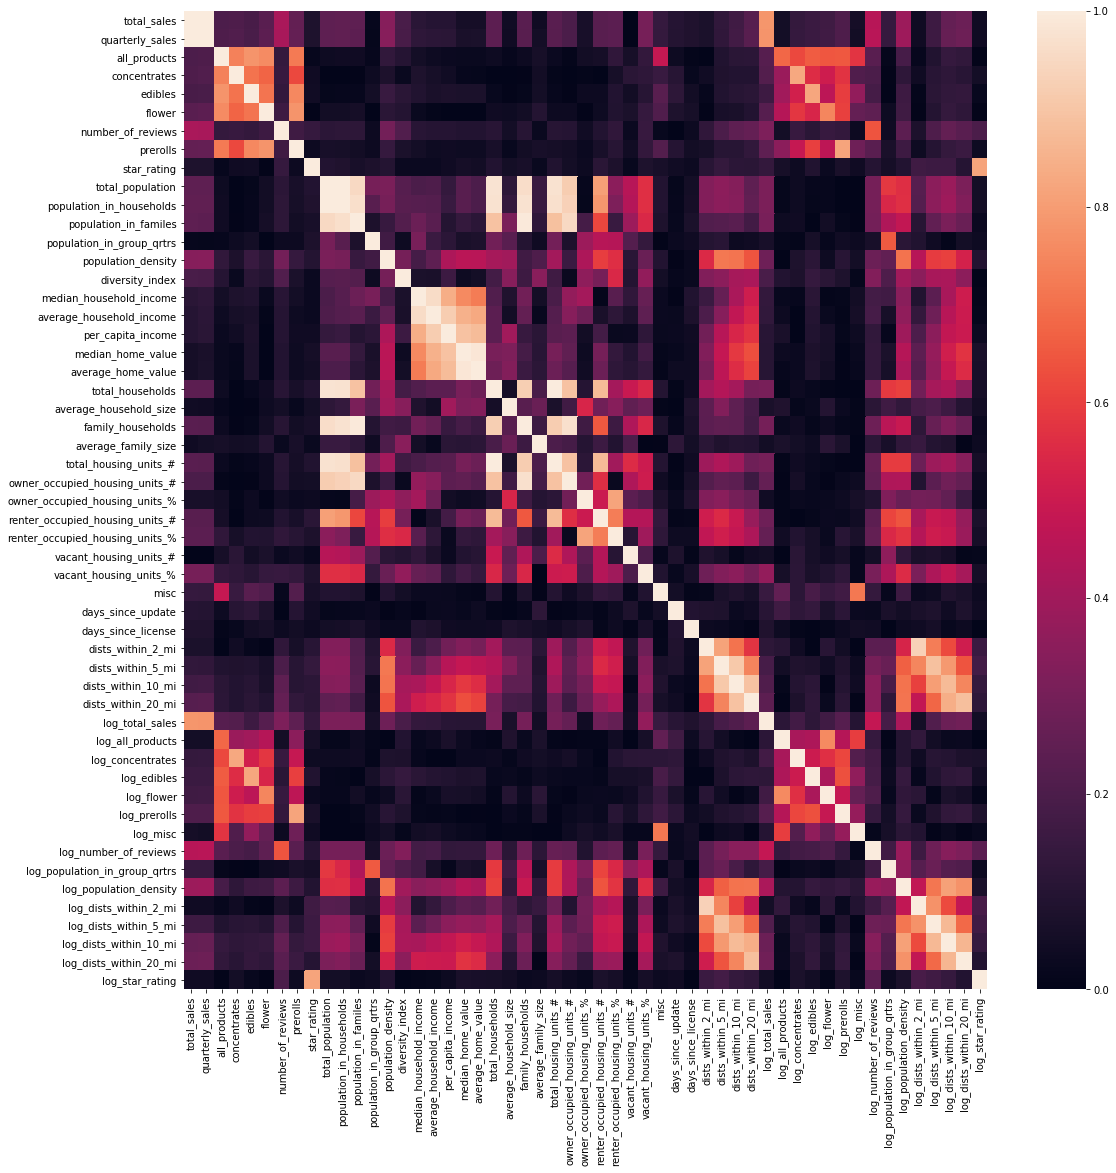

In [960]:
fig, ax = plt.subplots(figsize=(18,18))
sns.heatmap(numeric.corr().abs())

<Figure size 432x288 with 0 Axes>

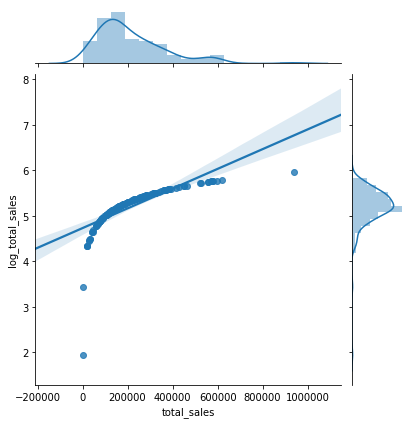

<Figure size 432x288 with 0 Axes>

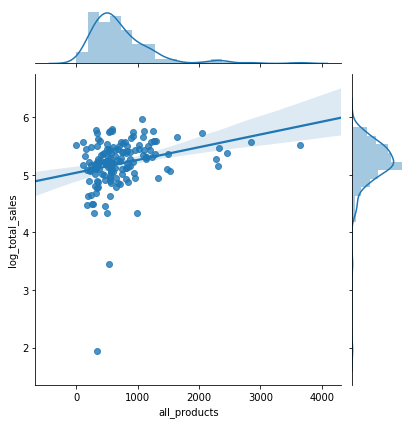

<Figure size 432x288 with 0 Axes>

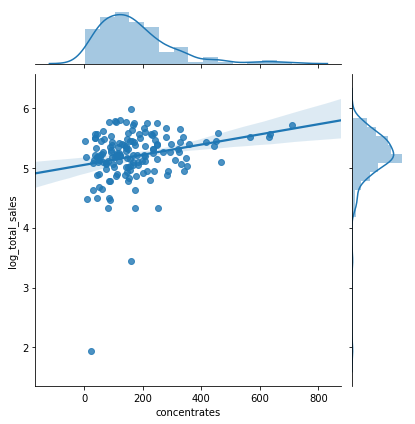

<Figure size 432x288 with 0 Axes>

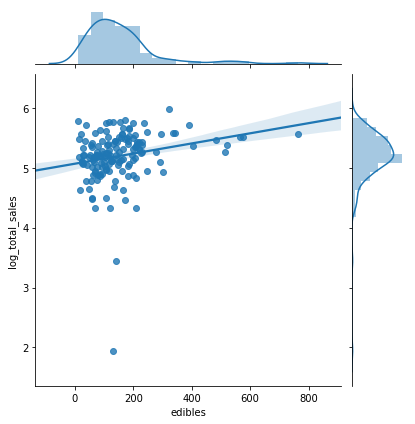

<Figure size 432x288 with 0 Axes>

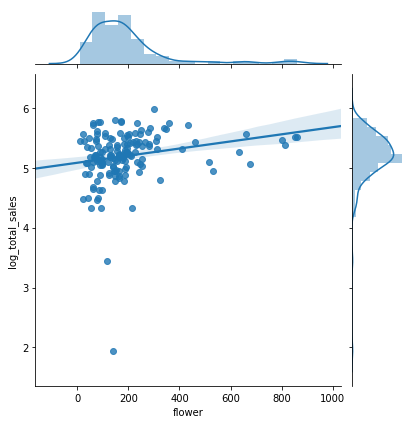

<Figure size 432x288 with 0 Axes>

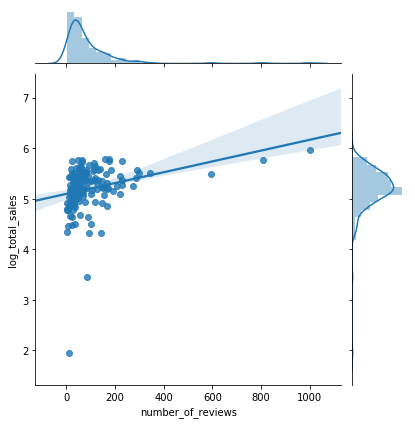

<Figure size 432x288 with 0 Axes>

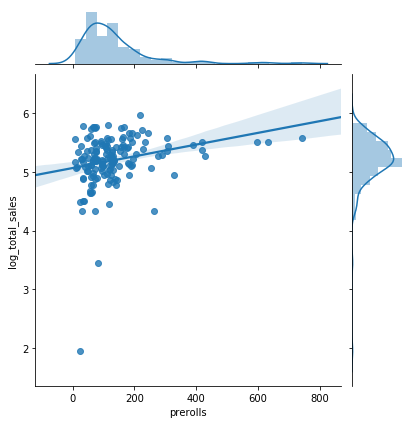

<Figure size 432x288 with 0 Axes>

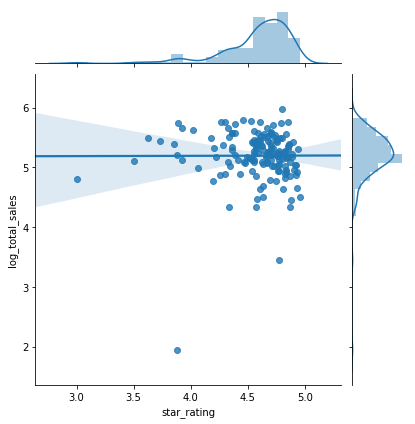

<Figure size 432x288 with 0 Axes>

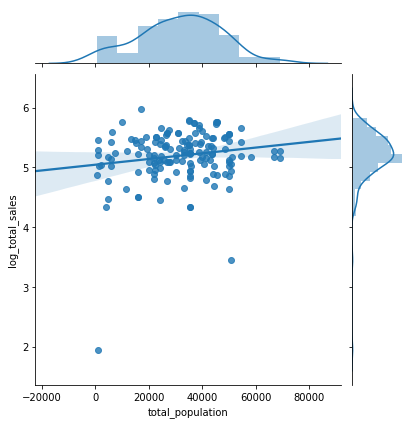

<Figure size 432x288 with 0 Axes>

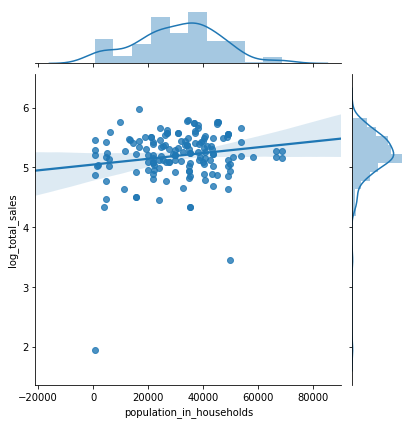

<Figure size 432x288 with 0 Axes>

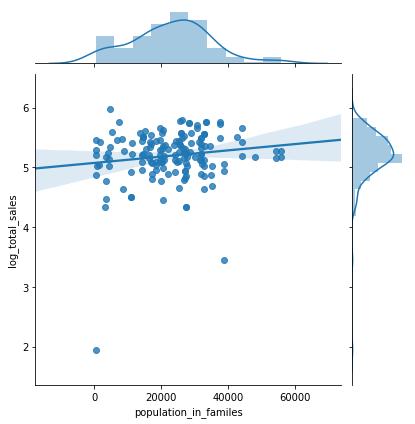

<Figure size 432x288 with 0 Axes>

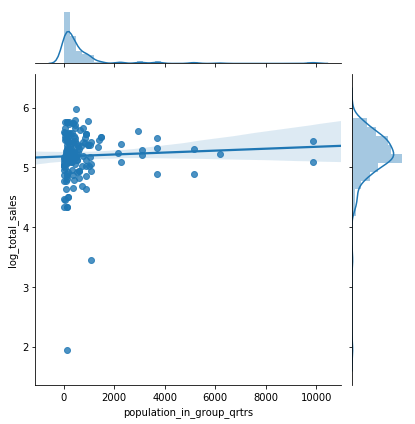

<Figure size 432x288 with 0 Axes>

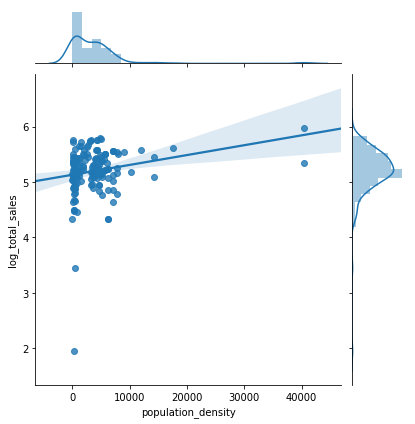

<Figure size 432x288 with 0 Axes>

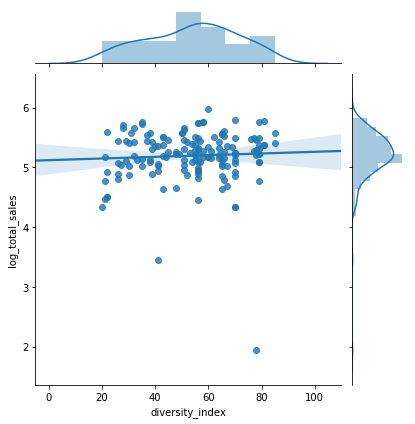

<Figure size 432x288 with 0 Axes>

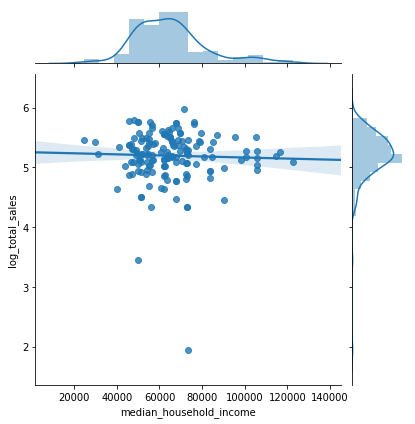

<Figure size 432x288 with 0 Axes>

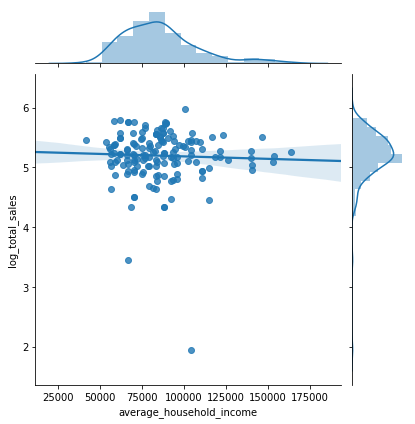

<Figure size 432x288 with 0 Axes>

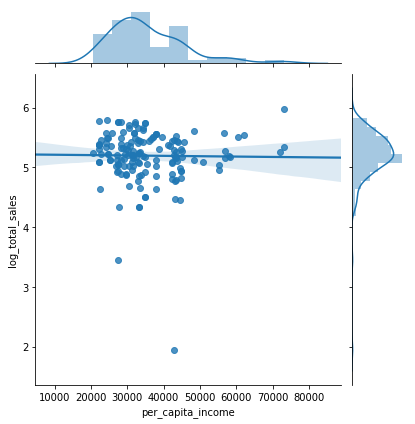

<Figure size 432x288 with 0 Axes>

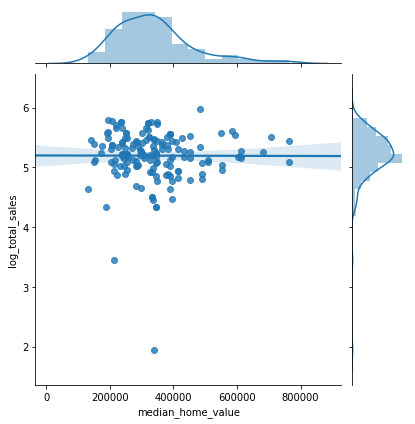

<Figure size 432x288 with 0 Axes>

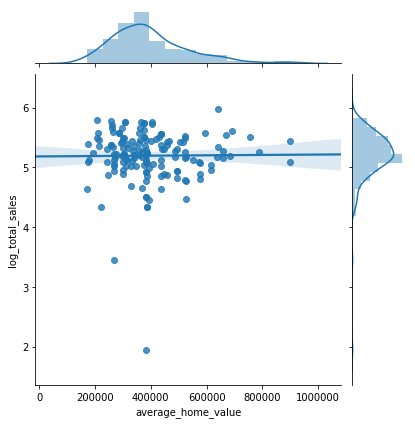

<Figure size 432x288 with 0 Axes>

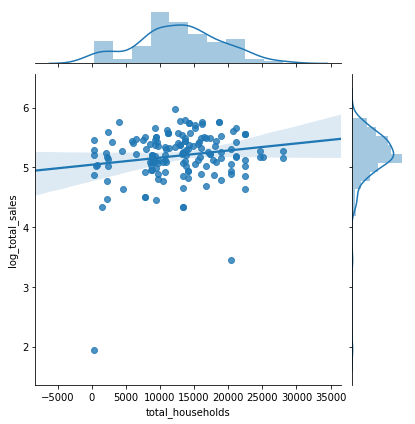

<Figure size 432x288 with 0 Axes>

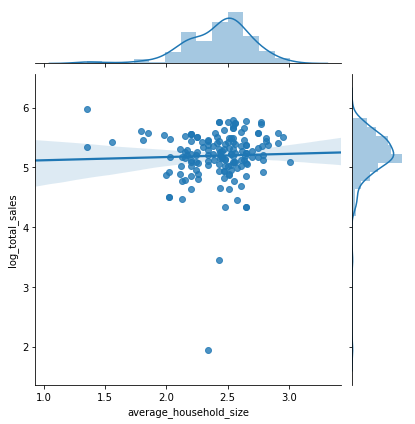

<Figure size 432x288 with 0 Axes>

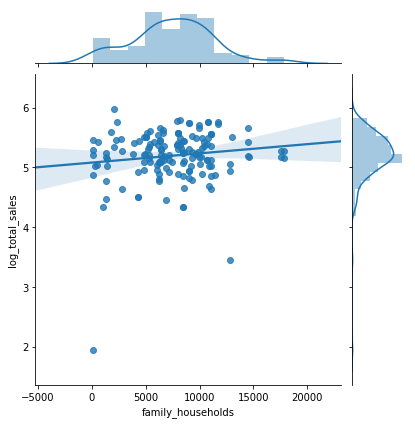

<Figure size 432x288 with 0 Axes>

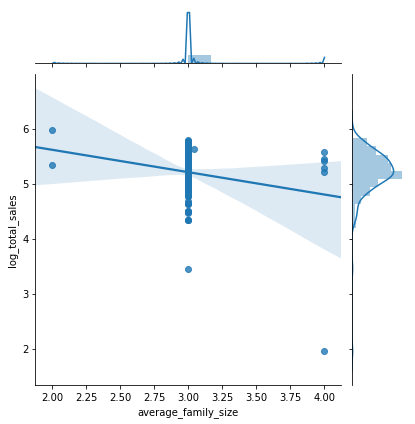

<Figure size 432x288 with 0 Axes>

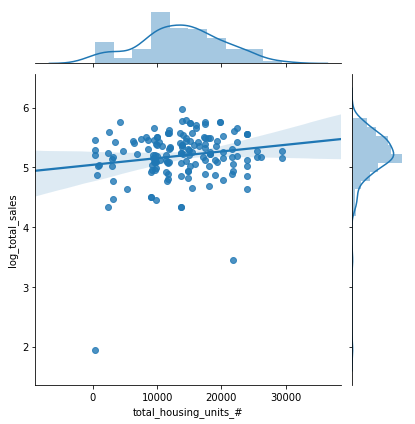

<Figure size 432x288 with 0 Axes>

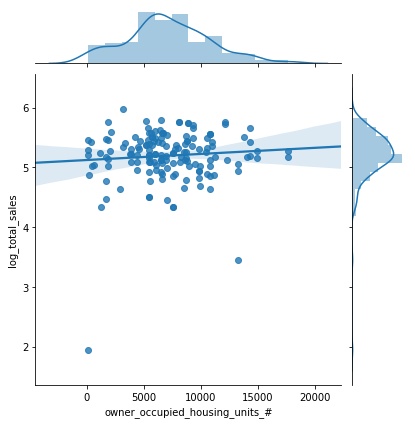

<Figure size 432x288 with 0 Axes>

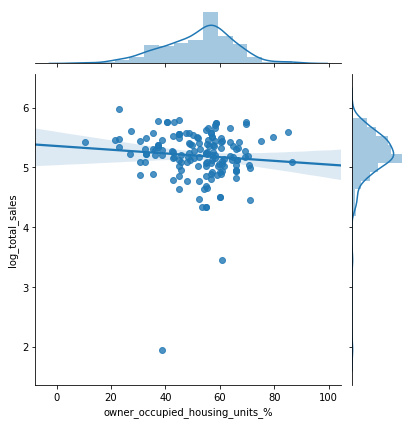

<Figure size 432x288 with 0 Axes>

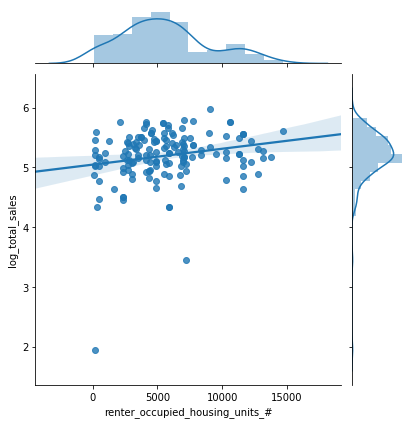

<Figure size 432x288 with 0 Axes>

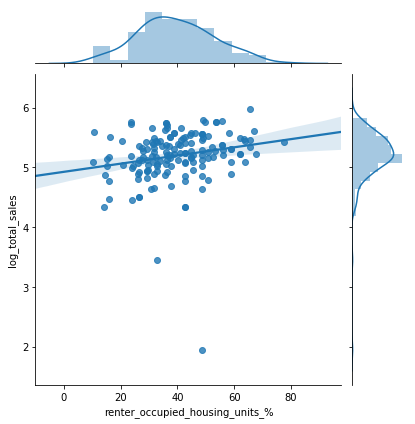

<Figure size 432x288 with 0 Axes>

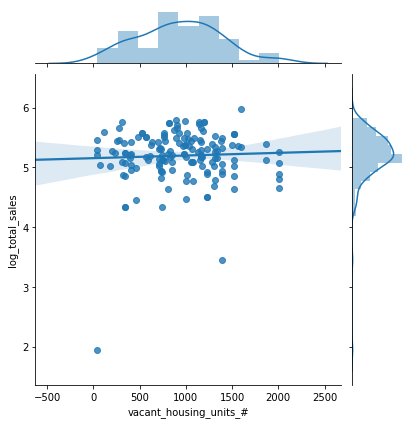

<Figure size 432x288 with 0 Axes>

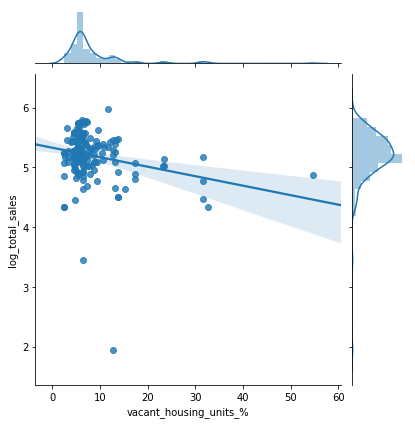

<Figure size 432x288 with 0 Axes>

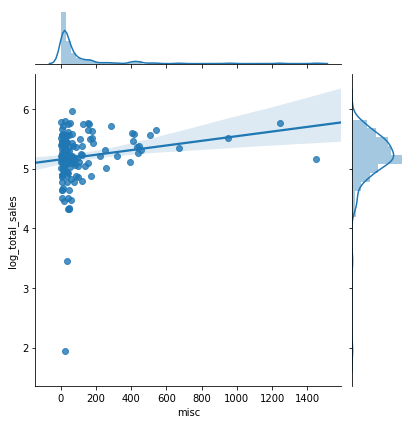

<Figure size 432x288 with 0 Axes>

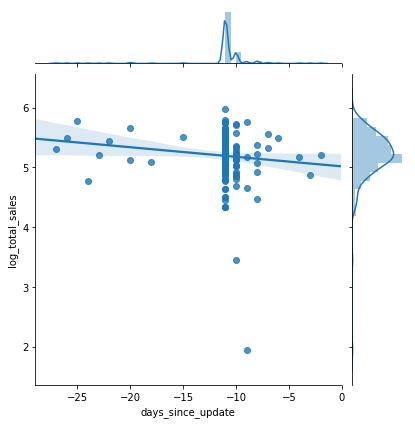

<Figure size 432x288 with 0 Axes>

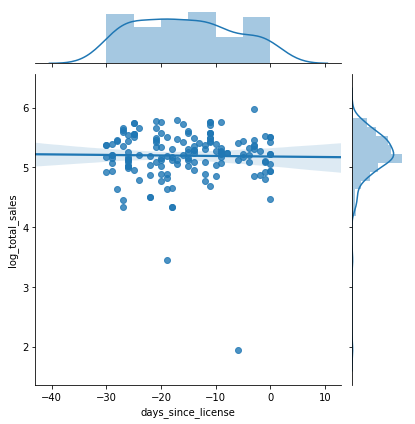

<Figure size 432x288 with 0 Axes>

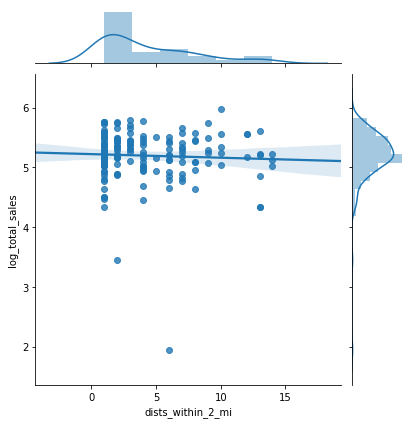

<Figure size 432x288 with 0 Axes>

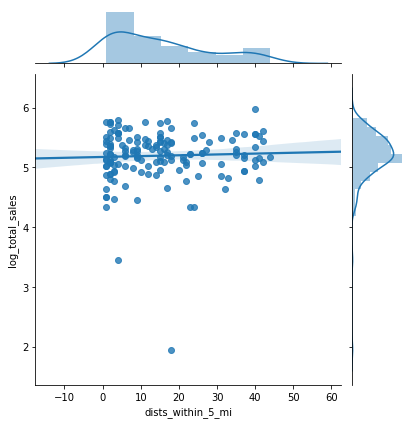

<Figure size 432x288 with 0 Axes>

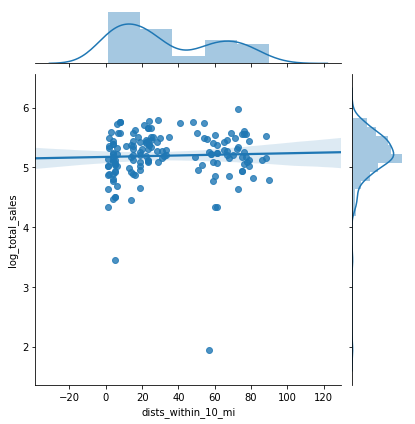

<Figure size 432x288 with 0 Axes>

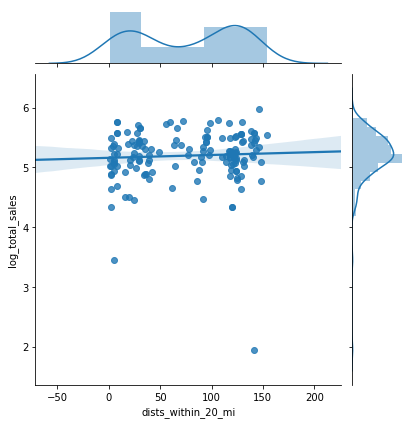

<Figure size 432x288 with 0 Axes>

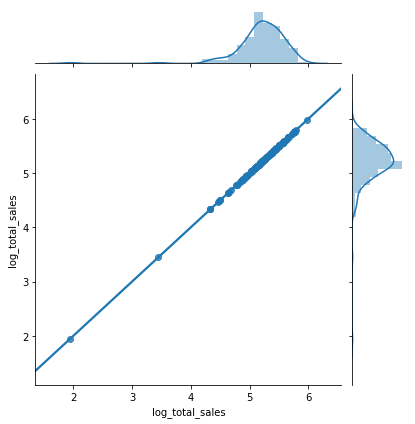

<Figure size 432x288 with 0 Axes>

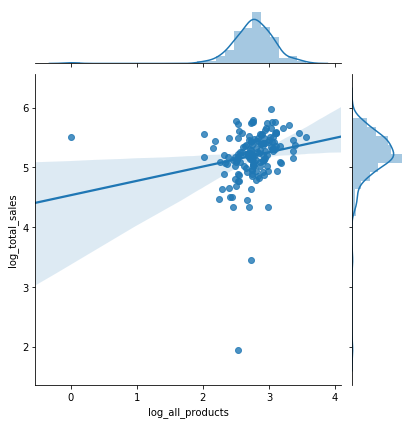

<Figure size 432x288 with 0 Axes>

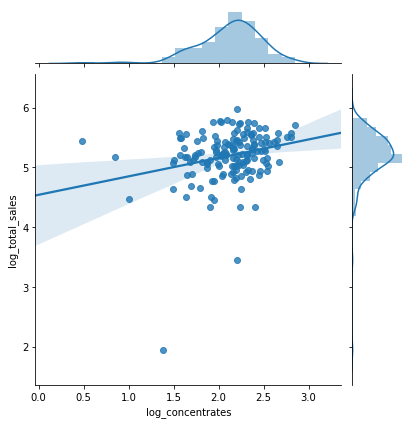

<Figure size 432x288 with 0 Axes>

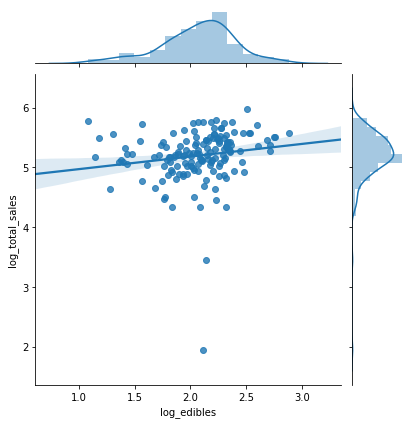

<Figure size 432x288 with 0 Axes>

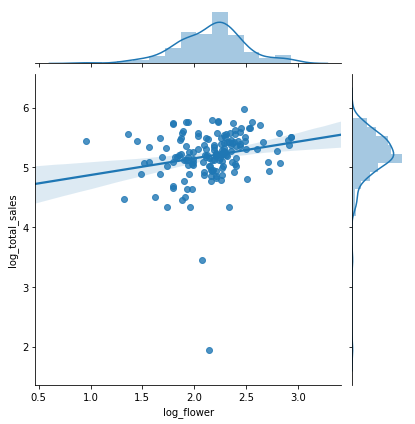

<Figure size 432x288 with 0 Axes>

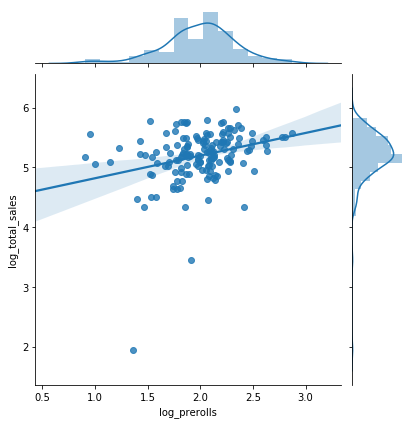

<Figure size 432x288 with 0 Axes>

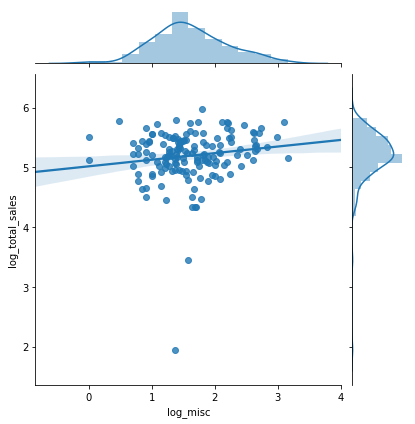

<Figure size 432x288 with 0 Axes>

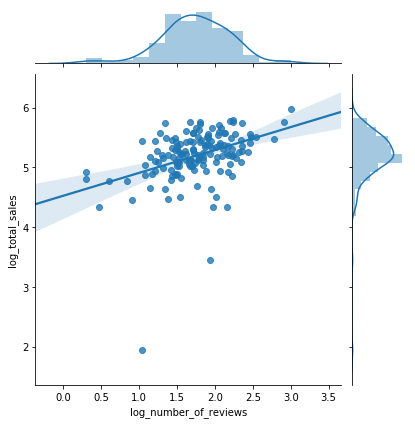

<Figure size 432x288 with 0 Axes>

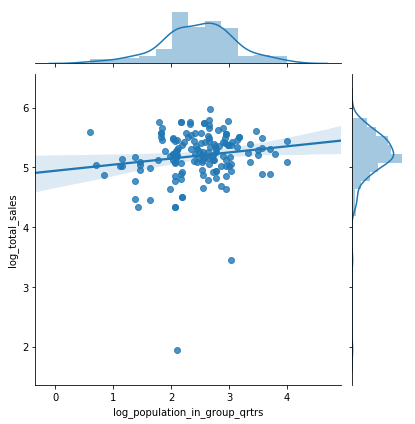

<Figure size 432x288 with 0 Axes>

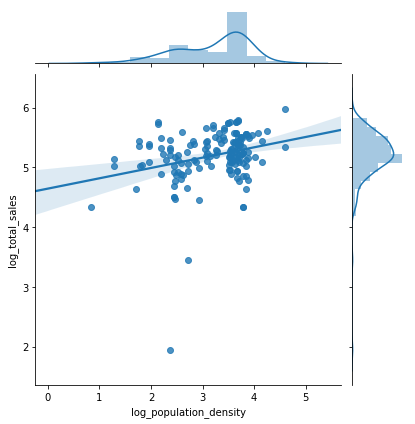

<Figure size 432x288 with 0 Axes>

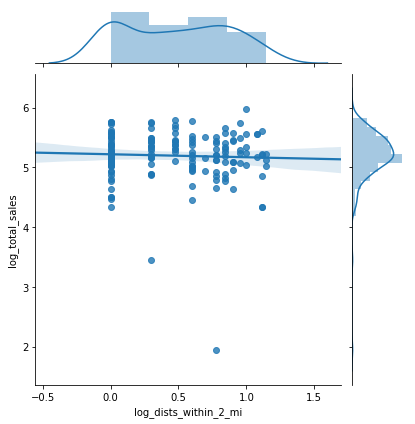

<Figure size 432x288 with 0 Axes>

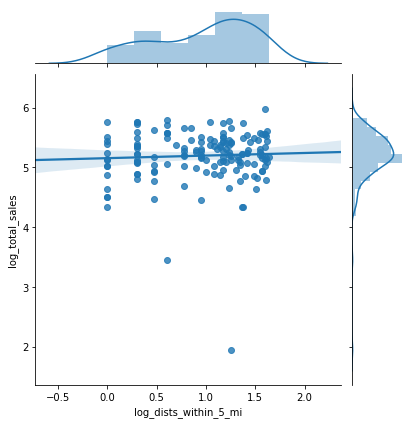

<Figure size 432x288 with 0 Axes>

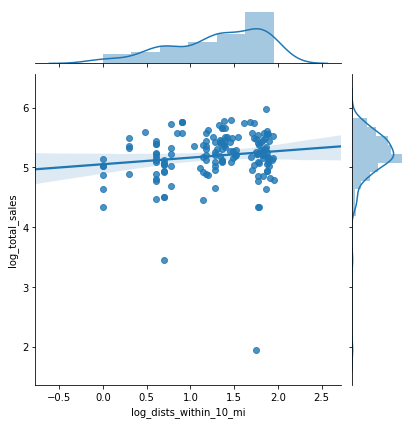

<Figure size 432x288 with 0 Axes>

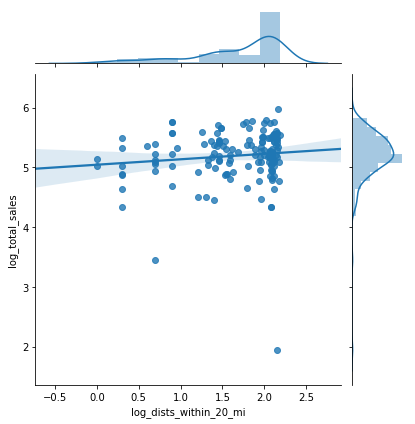

<Figure size 432x288 with 0 Axes>

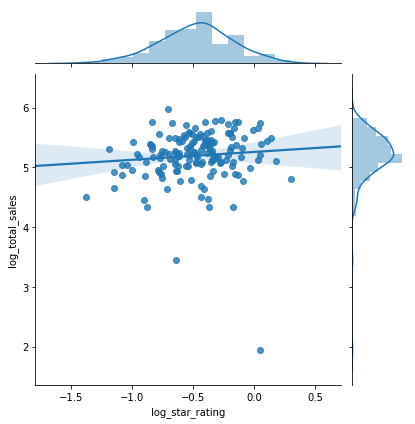

In [922]:
targets = ['total_sales', 'log_total_sales']

for i, col in enumerate(numeric.columns):   
    f = plt.figure()
    df = numeric.replace([np.inf, -np.inf], np.nan).dropna()
    sns.jointplot(x=col, y=targets[1], kind='reg', height=6, data=df);


# for i, col in enumerate(numeric.columns):   
#     df = numeric.replace([np.inf, -np.inf], np.nan).dropna()
#     J1 = sns.jointplot(x=col, y=targets[0], kind='reg', height=6, data=df)
#     J2 = sns.jointplot(x=col, y=targets[0], kind='resid', height=6, data=df)
#     J3 = sns.jointplot(x=col, y=targets[1], kind='reg', height=6, data=df)
#     J4 = sns.jointplot(x=col, y=targets[1], kind='resid', height=6, data=df)
    
#     f = plt.figure()
#     for J in [J1, J2, J3, J4]:
#         for A in J.fig.axes:
#             f._axstack.add(f._make_key(A), A)
    
#     #subplots size adjustment
#     width = 1
#     sub = 0.125
#     f.axes[0].set_position([sub, sub, width,  width])
#     f.axes[1].set_position([sub, width + sub, width,  sub])
#     f.axes[2].set_position([width + sub, sub, sub, width])
#     f.axes[3].set_position([width + 3 * sub, sub, width,  width])
#     f.axes[4].set_position([width + 3 * sub, width + sub, width,  sub])
#     f.axes[5].set_position([2 * width + 3 * sub, sub, sub, width])
#     f.axes[6].set_position([sub, width + 3 * sub, width,  width])
#     f.axes[7].set_position([sub, 2 * width + 3 * sub, width,  sub])
#     f.axes[8].set_position([width + sub, width + 3 * sub, sub, width])
#     f.axes[9].set_position([width + 3 * sub, width + 3 * sub, width,  width])
#     f.axes[10].set_position([width + 3 * sub, 2 * width + 3 * sub, width,  sub])
#     f.axes[11].set_position([2 * width + 3 * sub, width + 3 * sub, sub, width])

*Before moving on to exploratory analysis, write down some notes about challenges encountered while working with this data that might be helpful for anyone else (including yourself) who may work through this later on.*

# Explore the Data

*Before you start exploring the data, write out your thought process about what you're looking for and what you expect to find. Take a minute to confirm that your plan actually makes sense.*

*Calculate summary statistics and plot some charts to give you an idea what types of useful relationships might be in your dataset. Use these insights to go back and download additional data or engineer new features if necessary. Not now though... remember we're still just trying to finish the MVP!*

In [ ]:
## %%writefile ../src/visualization/visualize.py

# imports
# helper functions go here

def run():
    """
    Executes a set of helper functions that read files from 
    data/processed, calculates descriptive statistics for the population,
    and plots charts that visualize interesting relationships between 
    features.
    """
    # data = load_features('data/processed')
    # describe_features(data, 'reports/')
    # generate_charts(data, 'reports/figures/')
    pass


*What did you learn? What relationships do you think will be most helpful as you build your model?*

# Model the Data

*Describe the algorithm or algorithms that you plan to use to train with your data. How do these algorithms work? Why are they good choices for this data and problem space?*

In [763]:
## %%writefile ../src/models/train_model.py

# Imports
import pickle

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Helper functions

def save_to(item, path):
    """
    
    """
    with open(path, 'wb') as to_write:
        pickle.dump(item, to_write)
    
    return


def split_train_test(data):
    """
    
    """
#     X, y = data.drop('total_sales', axis=1), data['total_sales']

    # Hold out 20% of the data for final testing
    train, test = train_test_split(data, test_size=.2, random_state=69)
    return (train, test)


def load_features(filepath, target):
    """
    
    """
    data = pd.read_pickle(filepath)
    print(target)
#     target = ['log_total_sales']
#     cols = features + target
#     refined_data = data[cols]
    abs_corrs = data.corr()[target].abs().sort_values(by=target, ascending=False)
    features = list(abs_corrs[:16].drop(target).index)
    cols = features + target
    model_data = data[cols]
    
    return model_data
    
    
def run(rand=10):
    """
    Executes a set of helper functions that read files from 
    data/processed, calculates descriptive statistics for the population,
    and plots charts that visualize interesting relationships between 
    features.
    """
    path = '../data/processed/'
    filename = {
        'data': 'data.pkl',
        'train': 'train.pkl',
        'test': 'test.pkl'
    }
    targets = ['total_sales', 'log_total_sales']
    target = targets[0]
    data = load_features(path + filename['data'], target)
#     print(data.info())
    X, y = data.drop(targets, axis=1), data[target]

    # Hold out 20% of the data for final testing
    X, X_test, y, y_test = train_test_split(X, y, random_state=rand)
#     save_to(train, path + filename['train'])
#     save_to(test, path + filename['test'])
    
    lm1 = LinearRegression()
    lm1.fit(X, y)
    save_to(lm1, '../models/lm1.pkl')
    return lm1, X, X_test, y, y_test

In [744]:
## %%writefile ../src/models/predict_model.py

# imports
# helper functions go here

def run():
    """
    Executes a set of helper functions that read files from 
    data/processed, calculates descriptive statistics for the population,
    and plots charts that visualize interesting relationships between
    features.
    """
    # test_X, test_y = load_test_data('data/processed')
    # trained_model = load_model('models/')
    # predictions = trained_model.predict(test_X)
    # metrics = evaluate(test_y, predictions)
    # save_metrics('reports/')
    pass



_Write down any thoughts you may have about working with these algorithms on this data. What other ideas do you want to try out as you iterate on this pipeline?_

# Interpret the Model

_Write up the things you learned, and how well your model performed. Be sure address the model's strengths and weaknesses. What types of data does it handle well? What types of observations tend to give it a hard time? What future work would you or someone reading this might want to do, building on the lessons learned and tools developed in this project?_

In [246]:
from sklearn.metrics import mean_squared_error

In [764]:
lm1, X, X_test, y, y_test = run(rand=12)

print('Model Performance\n')
Rs = pd.DataFrame({'R^2': [lm1.score(X, y), lm1.score(X_test, y_test)]})
Rs.index = ['Train', 'Test']
display(Rs)

pd.DataFrame({'Features': list(X.columns), 'Coefficients': list(lm1.coef_)})

total_sales


TypeError: sort_values() got an unexpected keyword argument 'by'

Model Performance:



,Features,Coefficients
0,log_population_density,0.146807
1,vacant_housing_units_%,-0.023165
2,number_of_reviews,0.001367
3,population_in_households,-0.000277
4,total_population,0.000081
5,total_households,-0.000044
6,population_in_familes,0.000271
7,total_housing_units_#,0.000287
8,family_households,-0.000422
9,renter_occupied_housing_units_#,-0.000004


Text(0, 0.5, 'R^2')

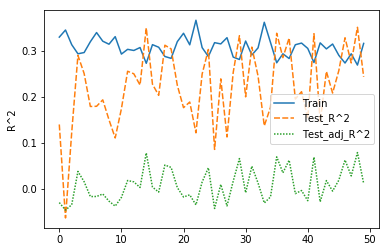

In [747]:
train_r = []
test_r = []
test_adj_r = []

for t in range(50):
    lm1, X, X_test, y, y_test = run(rand=t)
    train_r.append(lm1.score(X, y))
    R = lm1.score(X_test, y_test)
    test_r.append(R)
    y_pred = lm1.predict(X_test)
    n = len(X)
    p = len(X.columns)
    adj_r2 = 1 - (1-R**2)*(n-1)/(n-p-1)
    test_adj_r.append(adj_r2)
    
print('Model Performance:\n')
display(pd.DataFrame({'Features': list(X.columns), 'Coefficients': list(lm1.coef_)}))

Rs = pd.DataFrame({'Train': train_r, 'Test_R^2': test_r, 'Test_adj_R^2': test_adj_r})
# display(Rs)

# Rs.plot()
sns.lineplot(data=Rs)
plt.ylabel('R^2')

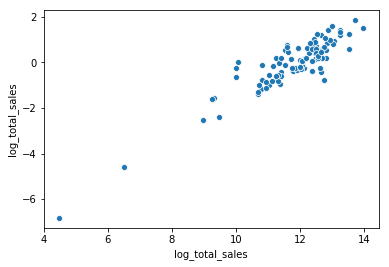

In [755]:
sns.scatterplot(y_test, y_test - y_pred);
# sns.resid

In [758]:
y_test.describe()

count    98.000000
mean     11.809942
std       1.354386
min       4.481872
25%      11.317141
50%      12.086409
75%      12.632537
max      13.978051
Name: log_total_sales, dtype: float64

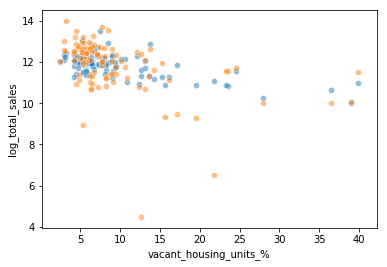

In [751]:
sns.scatterplot(X_test['vacant_housing_units_%'], y_pred, alpha=0.5)
sns.scatterplot(X_test['vacant_housing_units_%'], y_test, alpha=0.5)

In [752]:
mean_squared_error(y_test, y_pred)**.5

1.1722773830890783

In [753]:
mean_squared_error(y_test, y_pred)**.5 / (sum(y_test)/len(y_test))

0.09926190799473537